In [331]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/submission.csv
/kaggle/input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/train.csv
/kaggle/input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/test.csv


In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

In [333]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


****1. Downloading the data****

In [334]:
#submission_csv = pd.read_csv('../input/2022gdz22-datathon-case-2/submission.csv')
test_ = pd.read_csv('../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/test.csv')
test = test_.copy()
train_ = pd.read_csv('../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/train.csv')
train = train_.copy()

****2. EDA****

In [335]:
print('train obs. points:',train.shape[0])
print('test obs points:', test.shape[0])
test.shape[0]/(train.shape[0]+test.shape[0])

train obs. points: 105392
test obs points: 16751


0.13714252965786006

Test set accounts for 13.7% of whole data.

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI'>

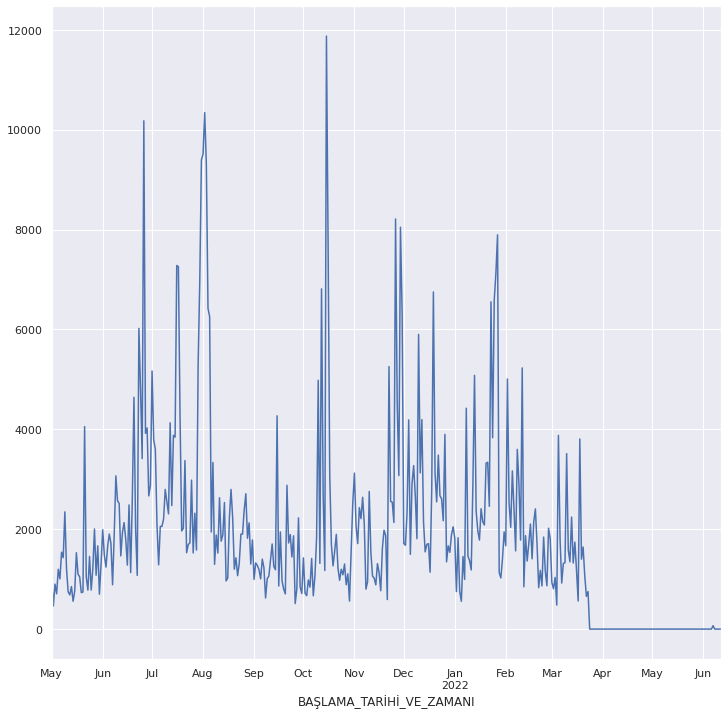

In [336]:
train['BAŞLAMA_TARİHİ_VE_ZAMANI'] = pd.to_datetime(train['BAŞLAMA_TARİHİ_VE_ZAMANI'], dayfirst = True)
train.set_index('BAŞLAMA_TARİHİ_VE_ZAMANI').resample('D')['cagri_count'].sum().plot()

In [337]:
train = train[train['BAŞLAMA_TARİHİ_VE_ZAMANI']< '2022-03-24 23:58:01' ]

In [338]:
train['BAŞLAMA_TARİHİ_VE_ZAMANI'].max()

Timestamp('2022-03-24 23:46:49')

In [339]:
train['BAŞLAMA_TARİHİ_VE_ZAMANI'].min()

Timestamp('2021-05-01 00:33:23')

In [340]:
# Column that existing in train but not in test.
[col for col in train.columns if col not in test.columns]
# cagri_count is the target column.

['KOD_NO', 'cagri_count']

In [341]:
# Column that is existing in test but not in train.
[col for col in test.columns if col not in train.columns]

[]

In [342]:
# Quick glance at a dataset
def check_df(data, x=5):
    print('################################# shape ##########################')
    print(data.shape )
    print('################################# type ##########################')
    print(data.dtypes)
    print('################################# head ##########################')
    #print(data.head(x))
    print('################################# tail ##########################')
    #print(data.tail(x))
    print('################################# null ##########################')
    print(data.isnull().sum().to_frame(name = 'counts').query('counts>0').sort_values(by = 'counts',ascending=False))
    print('################################# quantiles #####################')
    print(data.describe([0, 0.05, 0.5, 0.95, 0.99, 1]).T)
check_df(train)

################################# shape ##########################
(86456, 29)
################################# type ##########################
KESİNTİ_NO                                    int64
İL                                           object
İLÇE                                         object
ŞEBEKE_UNSURU                                object
ŞEBEKE_UNSURU_KODU                           object
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA            object
KAYNAĞA_GÖRE                                 object
SÜREYE_GÖRE                                  object
SEBEBE_GÖRE                                  object
BİLDİRİME_GÖRE                               object
BAŞLAMA_TARİHİ_VE_ZAMANI             datetime64[ns]
SONA_ERME_TARİHİ_VE_ZAMANI                   object
KESİNTİ_SÜRESİ                              float64
KENTSEL_OG                                    int64
KENTSEL_AG                                    int64
KENTALTI_OG                                   int64
KENTALTI_AG            

In [343]:
check_df(test)

################################# shape ##########################
(16751, 27)
################################# type ##########################
KESİNTİ_NO                             int64
İL                                    object
İLÇE                                  object
ŞEBEKE_UNSURU                         object
ŞEBEKE_UNSURU_KODU                    object
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA     object
KAYNAĞA_GÖRE                          object
SÜREYE_GÖRE                           object
SEBEBE_GÖRE                           object
BİLDİRİME_GÖRE                        object
BAŞLAMA_TARİHİ_VE_ZAMANI              object
SONA_ERME_TARİHİ_VE_ZAMANI            object
KESİNTİ_SÜRESİ                       float64
KENTSEL_OG                             int64
KENTSEL_AG                             int64
KENTALTI_OG                            int64
KENTALTI_AG                            int64
KIRSAL_OG                              int64
KIRSAL_AG                              int64


It seems that we have got some outliers in 'KESINTI_SURESI', 'KENTSEL_OG', 'KENTSEL_AG', 'KENTALTI_AG'... since the mean and the median of those values are not similar. Also, some of the values does not fit in normal distribution.

In [344]:
# Concatination of the test and the train set
df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

In [345]:
def grab_col_names (dataframe, categorical = 10, cardinal =20):

    # categoricals
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    #  [col for col in df.columns if str(df[col].dtypes) in ["category","object","bool"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype == 'O' and
                   dataframe[col].nunique() > cardinal]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                   dataframe[col].nunique() < categorical]
    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numericals

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names (df, categorical = 10, cardinal =20)

Observations: 103207
Variables: 30
cat_cols: 9
num_cols: 16
cat_but_car: 5
num_but_cat: 2


We have 8 Categorical Columns and 16 Numerical columns. From categoricals, 5 of them has high cardinality.

In [346]:
cat_cols

['İL',
 'ŞEBEKE_UNSURU',
 'KAYNAĞA_GÖRE',
 'SÜREYE_GÖRE',
 'SEBEBE_GÖRE',
 'BİLDİRİME_GÖRE',
 'ind',
 'KADEME',
 'KOD_NO']

In [347]:
num_cols

['KESİNTİ_NO',
 'KESİNTİ_SÜRESİ',
 'KENTSEL_OG',
 'KENTSEL_AG',
 'KENTALTI_OG',
 'KENTALTI_AG',
 'KIRSAL_OG',
 'KIRSAL_AG',
 'TOPLAM_KENTSEL_OG',
 'TOPLAM_KENTSEL_AG',
 'TOPLAM_KENTALTI_OG',
 'TOPLAM_KENTALTI_AG',
 'TOPLAM_KIRSAL_OG',
 'TOPLAM_KIRSAL_AG',
 'OutageID',
 'cagri_count']

In [348]:
df.head()

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KADEME,OutageID,ind,KOD_NO,cagri_count
0,2342571,İZMİR,BORNOVA,OG Fideri,M-331 35-02-M00331_M-429 M02_2034177,Manevra,Dağıtım-OG,Kısa,Şebeke işletmecisi,Bildirimsiz,09.07.2022 22:49:22,09.07.2022 22:50:55,0.026,16,178,0,0,0,0,0.413,4.598,0.000,0.000,0.000,0.000,1.000,2342571,test,NaN,NaN
1,2361468,İZMİR,BORNOVA,OG Fideri,M-331 35-02-M00331_M-429 M02_2034177,OG Kesici Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,13.08.2022 13:24:14,13.08.2022 14:15:21,0.852,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2361468,test,NaN,NaN
2,2361553,İZMİR,BORNOVA,OG Fideri,M-331 35-02-M00331_M-429 M02_2034177,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,13.08.2022 16:44:49,13.08.2022 17:35:59,0.853,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2361553,test,NaN,NaN
3,2334266,İZMİR,URLA,OG Fideri,TR-132 35-19-L00132_DIREK TIPI TRAFO HUCRESI H...,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,26.06.2022 07:49:06,26.06.2022 09:33:18,1.737,1,46,0,0,0,0,1.737,79.887,0.000,0.000,0.000,0.000,1.000,2334266,test,NaN,NaN
4,2366079,İZMİR,ÇEŞME,OG Fideri,L-474 35-18-L00474_DIREK TIPI TRAFO HUCRESI H0...,OG Ayırıcı Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,21.08.2022 17:12:03,21.08.2022 17:33:00,0.349,0,0,1,65,0,0,0.000,0.000,0.349,22.696,0.000,0.000,1.000,2366079,test,NaN,NaN


##################### KESİNTİ_NO ############################
count    103207.000
mean    2090844.931
std      184116.179
min     1805939.000
5%      1818480.300
10%     1833829.400
20%     1882326.400
30%     1906928.800
40%     2044992.400
50%     2139039.000
60%     2179914.200
70%     2224109.800
80%     2257848.800
90%     2341500.800
95%     2352963.700
99%     2363084.880
max     2366166.000
Name: KESİNTİ_NO, dtype: float64


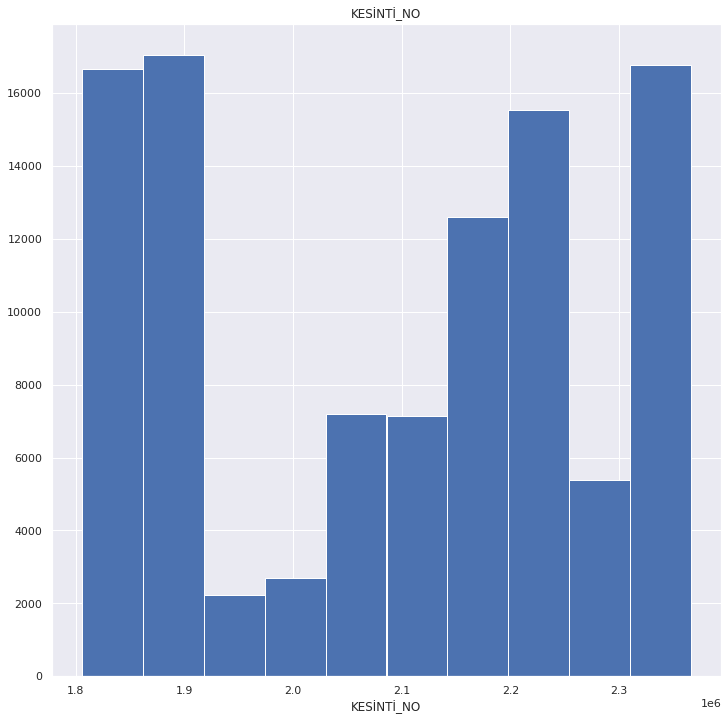

##################### KESİNTİ_SÜRESİ ############################
count   103207.000
mean         2.339
std          2.606
min          0.000
5%           0.148
10%          0.416
20%          0.767
30%          1.066
40%          1.364
50%          1.702
60%          2.106
70%          2.641
80%          3.453
90%          4.981
95%          6.563
99%         10.027
max        289.323
Name: KESİNTİ_SÜRESİ, dtype: float64


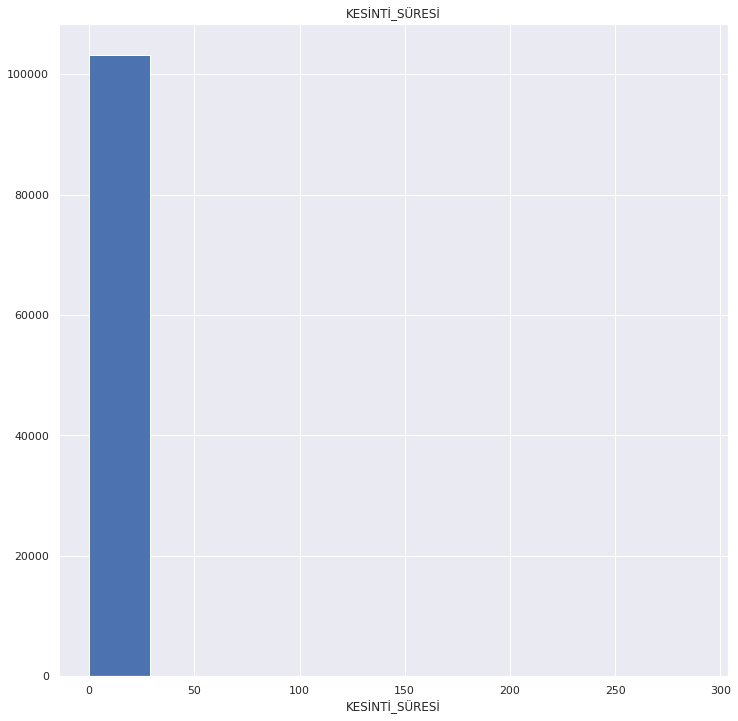

##################### KENTSEL_OG ############################
count   103207.000
mean         7.785
std         36.850
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          1.000
90%         15.000
95%         43.000
99%        149.000
max       1984.000
Name: KENTSEL_OG, dtype: float64


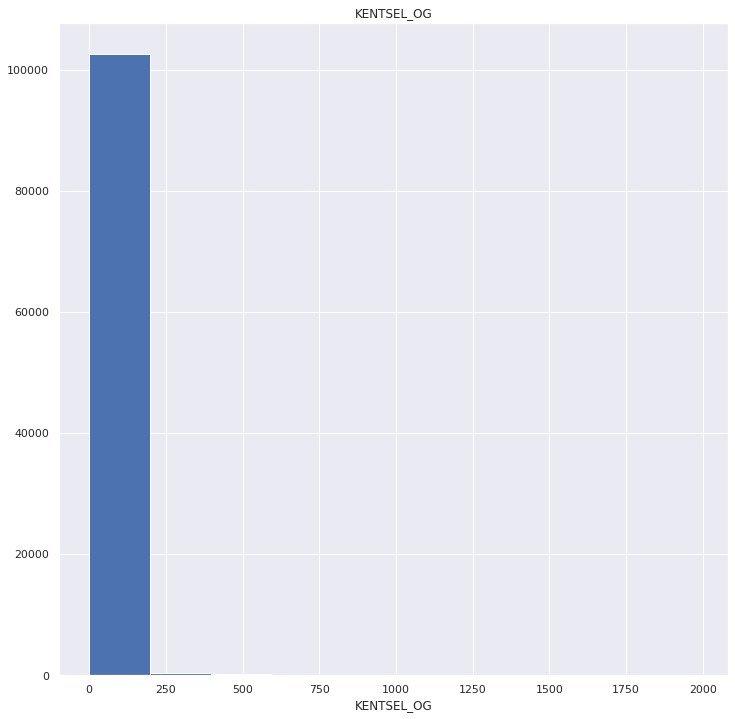

##################### KENTSEL_AG ############################
count   103207.000
mean       358.684
std       1700.934
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          1.000
40%          1.000
50%          4.000
60%         14.000
70%         53.000
80%        148.000
90%        552.000
95%       1544.000
99%       7253.860
max      70961.000
Name: KENTSEL_AG, dtype: float64


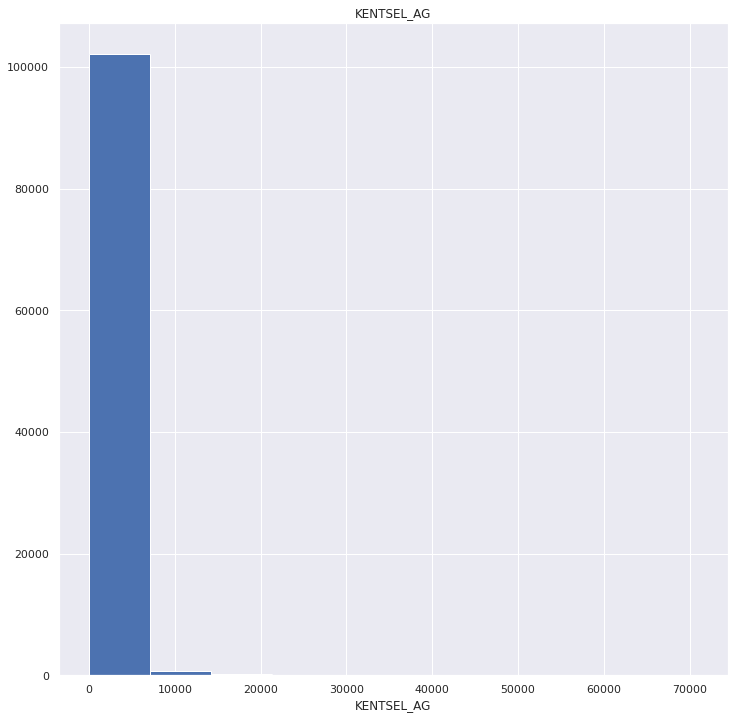

##################### KENTALTI_OG ############################
count   103207.000
mean         1.293
std         12.632
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          1.000
99%         34.000
max        750.000
Name: KENTALTI_OG, dtype: float64


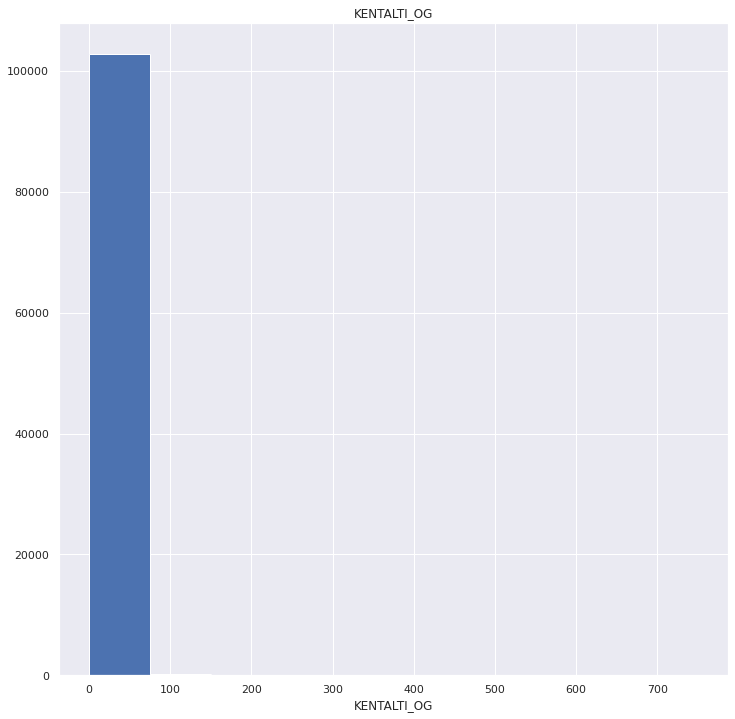

##################### KENTALTI_AG ############################
count   103207.000
mean        63.119
std        611.655
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%         10.000
95%         90.000
99%       1457.000
max      44781.000
Name: KENTALTI_AG, dtype: float64


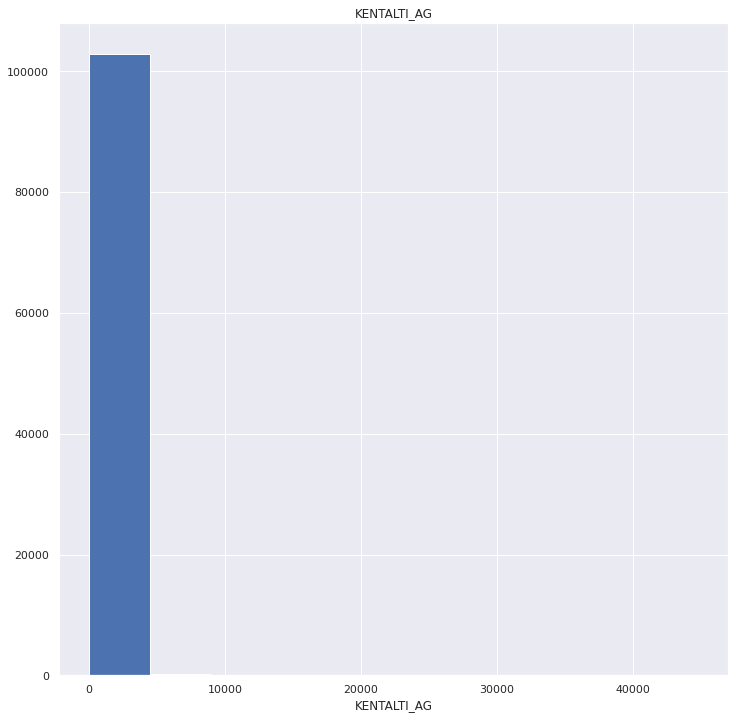

##################### KIRSAL_OG ############################
count   103207.000
mean         2.388
std         16.062
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          6.000
99%         64.000
max        478.000
Name: KIRSAL_OG, dtype: float64


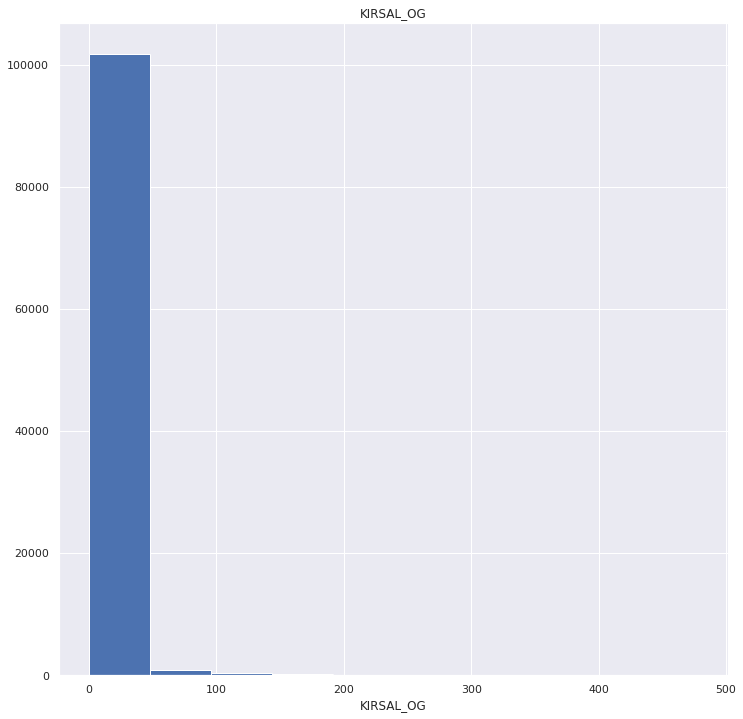

##################### KIRSAL_AG ############################
count   103207.000
mean        64.564
std        394.433
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%         28.000
95%        276.000
99%       1519.000
max      11673.000
Name: KIRSAL_AG, dtype: float64


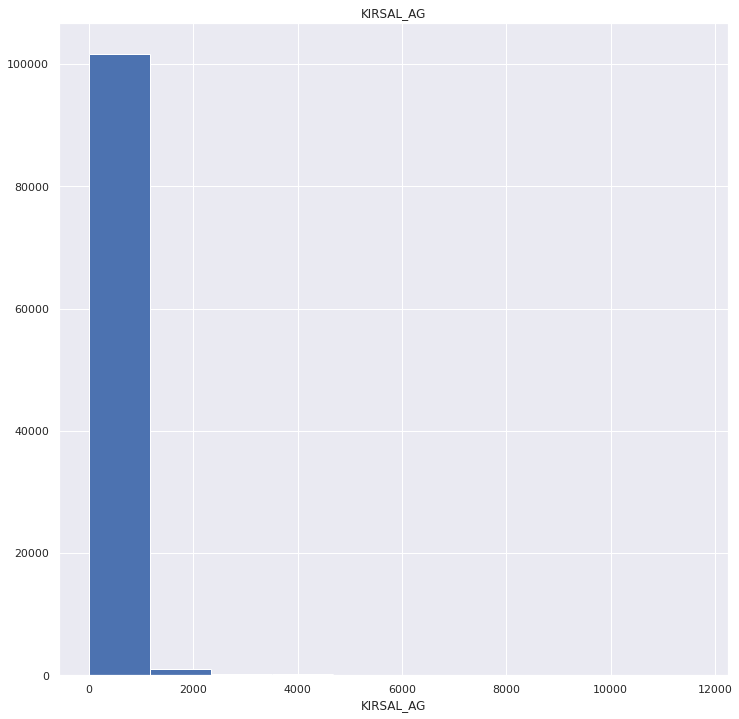

##################### TOPLAM_KENTSEL_OG ############################
count   103207.000
mean         7.462
std         58.432
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.262
90%          8.143
95%         28.801
99%        152.650
max       6374.702
Name: TOPLAM_KENTSEL_OG, dtype: float64


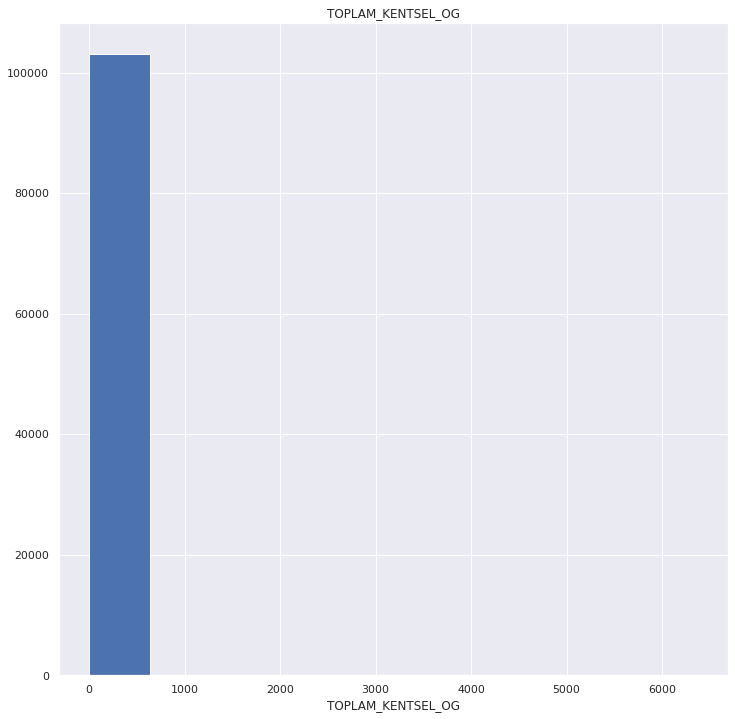

##################### TOPLAM_KENTSEL_AG ############################
count   103207.000
mean       305.807
std       1737.830
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.525
40%          2.665
50%          7.461
60%         24.329
70%         71.760
80%        195.996
90%        555.616
95%       1264.562
99%       5159.438
max     216061.921
Name: TOPLAM_KENTSEL_AG, dtype: float64


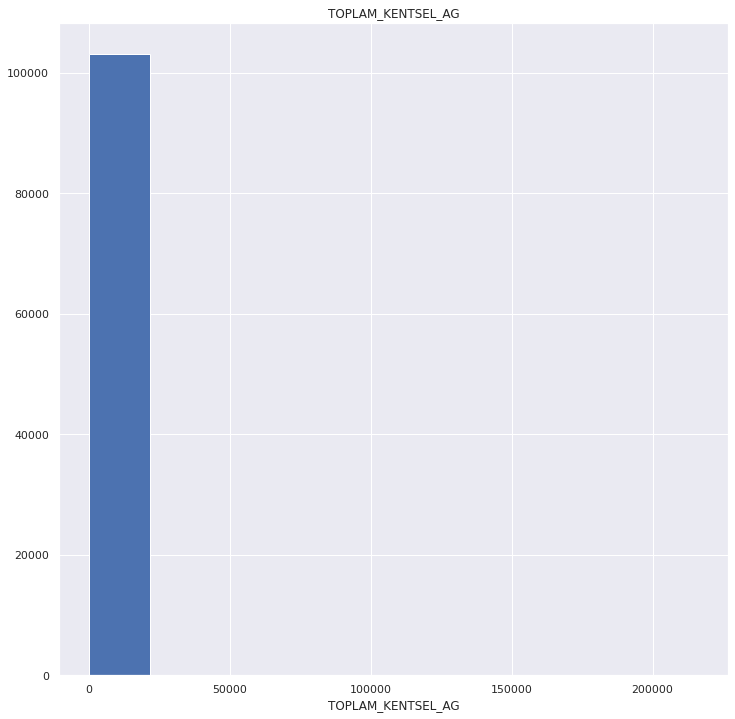

##################### TOPLAM_KENTALTI_OG ############################
count   103207.000
mean         0.969
std         15.380
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.306
99%         18.086
max       1711.691
Name: TOPLAM_KENTALTI_OG, dtype: float64


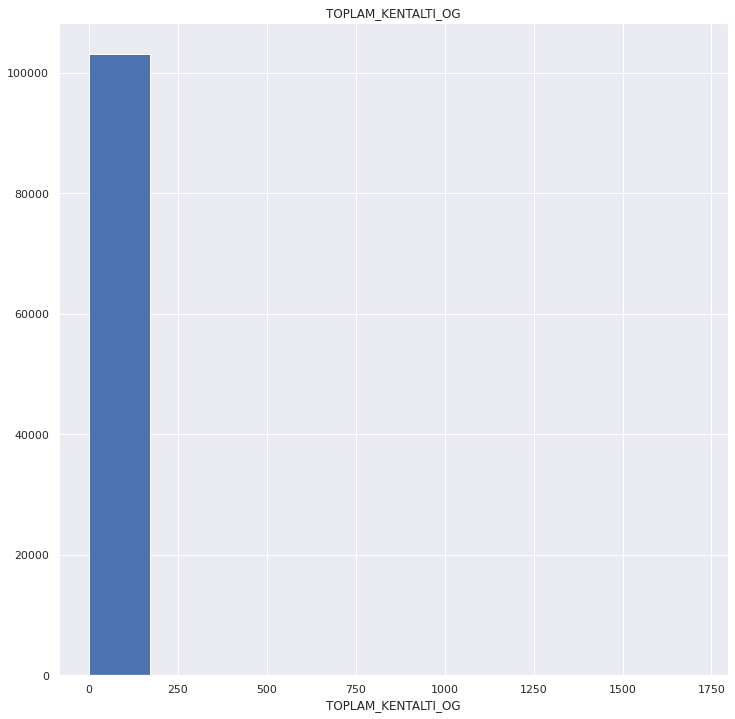

##################### TOPLAM_KENTALTI_AG ############################
count   103207.000
mean        42.408
std        494.354
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%         11.417
95%         91.581
99%        854.277
max      56916.000
Name: TOPLAM_KENTALTI_AG, dtype: float64


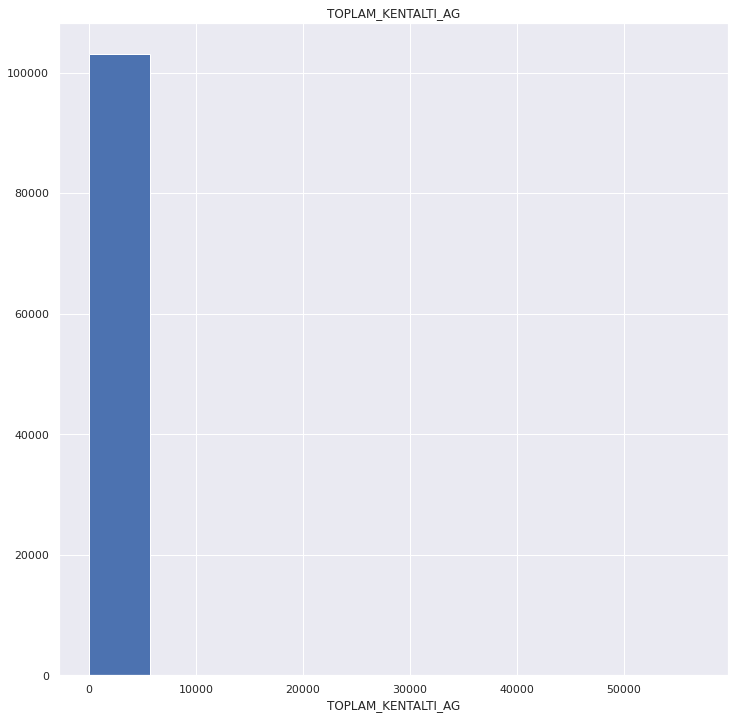

##################### TOPLAM_KIRSAL_OG ############################
count   103207.000
mean         1.714
std         19.229
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          2.059
99%         38.371
max       2090.578
Name: TOPLAM_KIRSAL_OG, dtype: float64


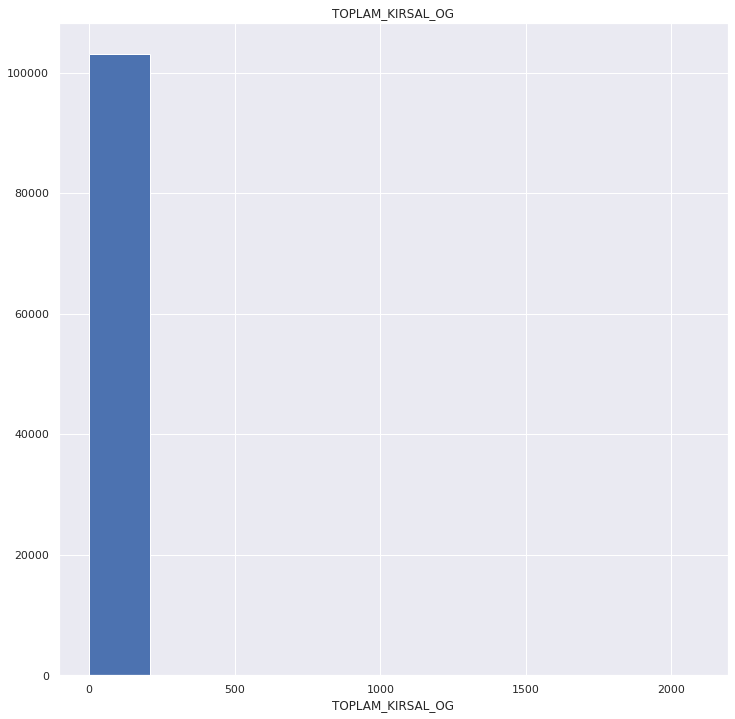

##################### TOPLAM_KIRSAL_AG ############################
count   103207.000
mean        46.353
std        433.077
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%         29.177
95%        160.636
99%        992.806
max      57794.541
Name: TOPLAM_KIRSAL_AG, dtype: float64


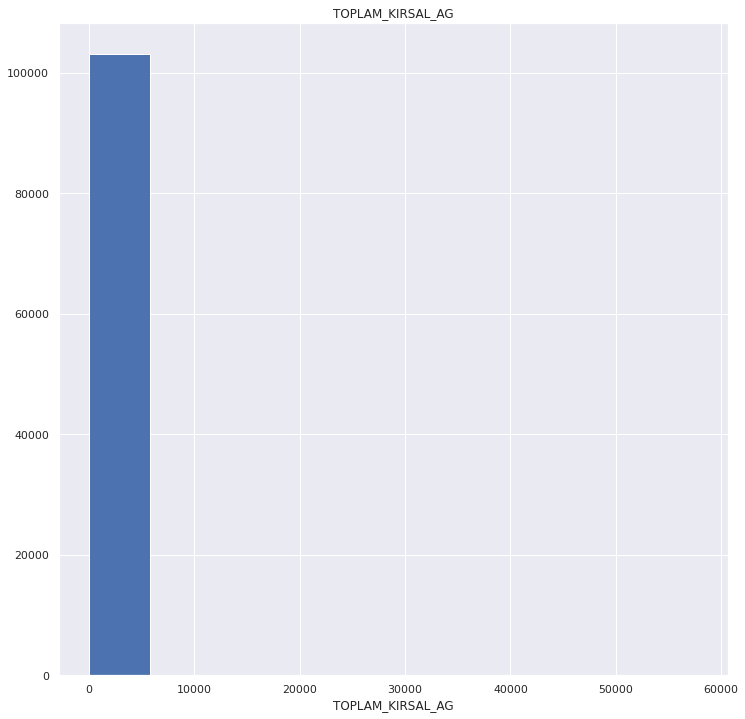

##################### OutageID ############################
count    103207.000
mean    2090844.931
std      184116.179
min     1805939.000
5%      1818480.300
10%     1833829.400
20%     1882326.400
30%     1906928.800
40%     2044992.400
50%     2139039.000
60%     2179914.200
70%     2224109.800
80%     2257848.800
90%     2341500.800
95%     2352963.700
99%     2363084.880
max     2366166.000
Name: OutageID, dtype: float64


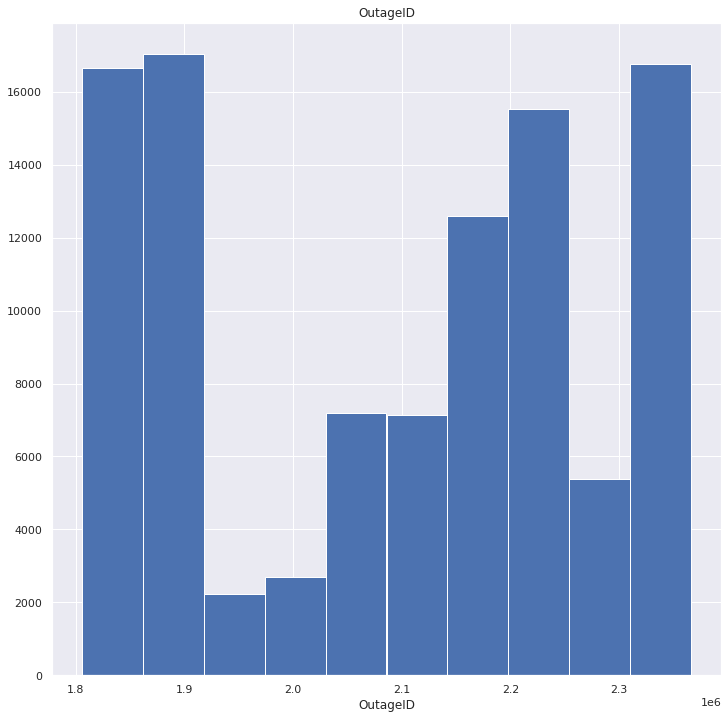

##################### cagri_count ############################
count   86456.000
mean        8.788
std        35.243
min         0.000
5%          0.000
10%         0.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         3.000
70%         4.000
80%         8.000
90%        17.000
95%        34.000
99%       115.000
max      2431.000
Name: cagri_count, dtype: float64


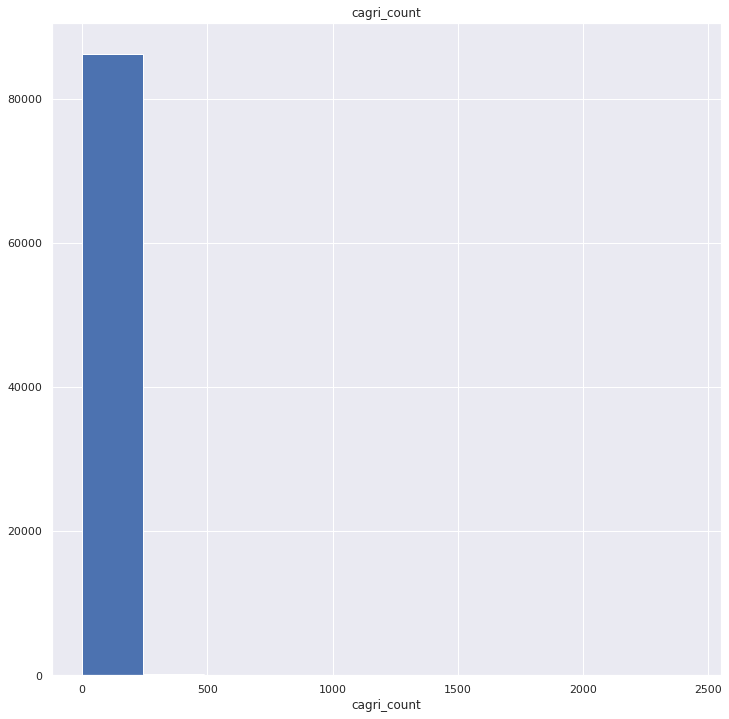

In [349]:
# Numerical Variable Analysis
def num_summary(dataframe, numeric_col, plot=False):
    print('#####################', numeric_col,'############################')
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numeric_col].describe(quantiles).T)

    if plot:
        dataframe[numeric_col].hist()
        plt.xlabel(numeric_col)
        plt.title(numeric_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

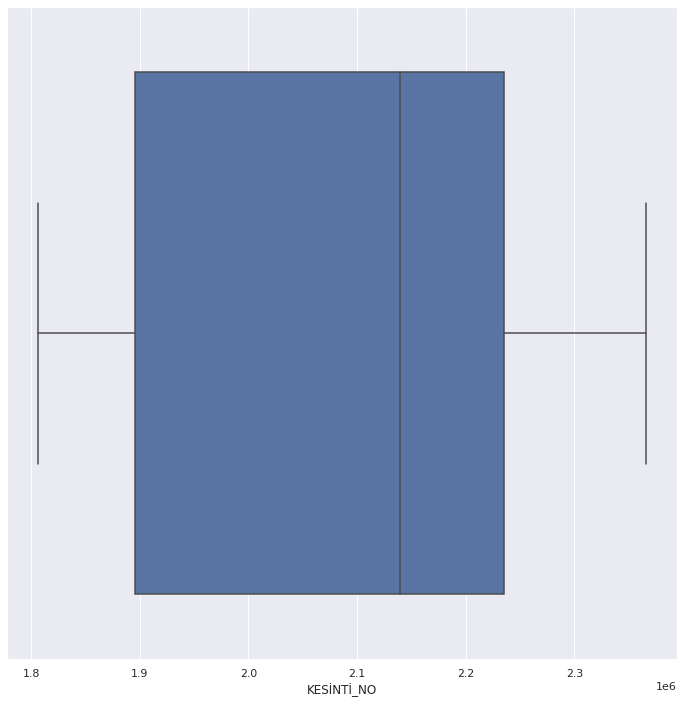

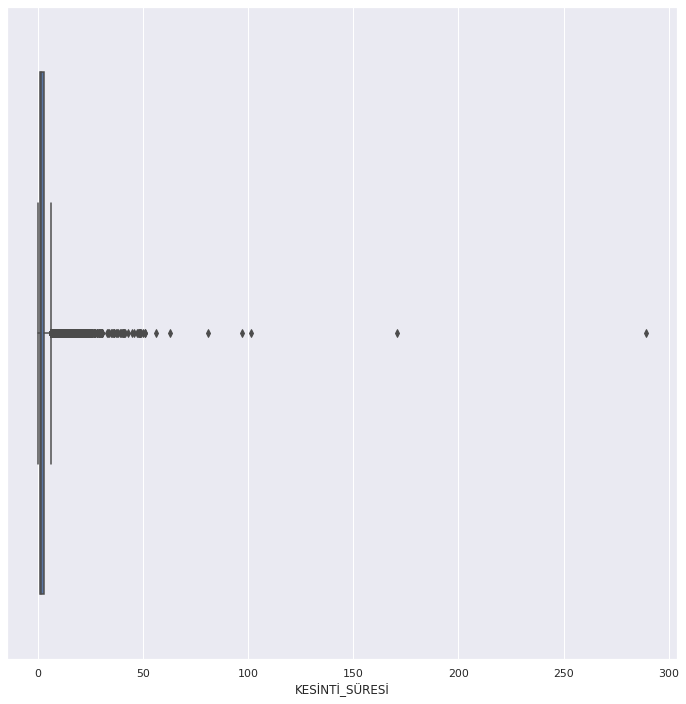

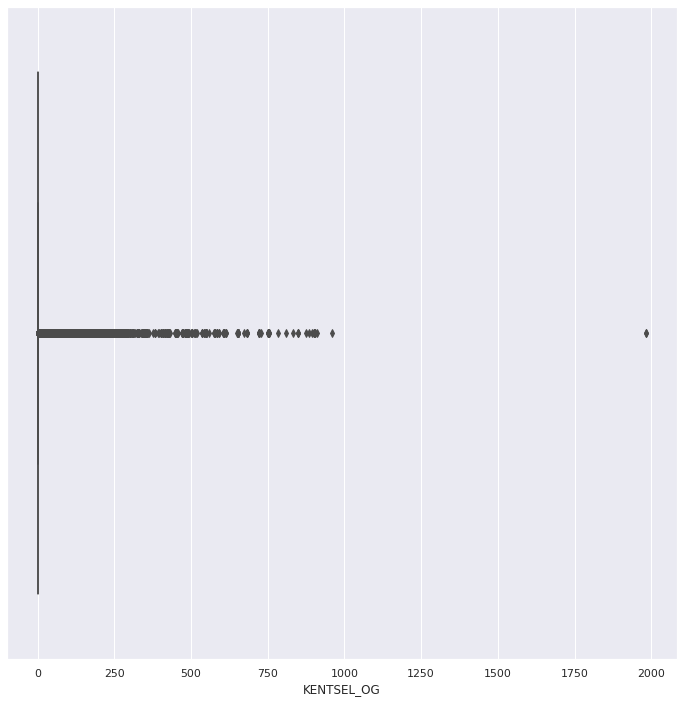

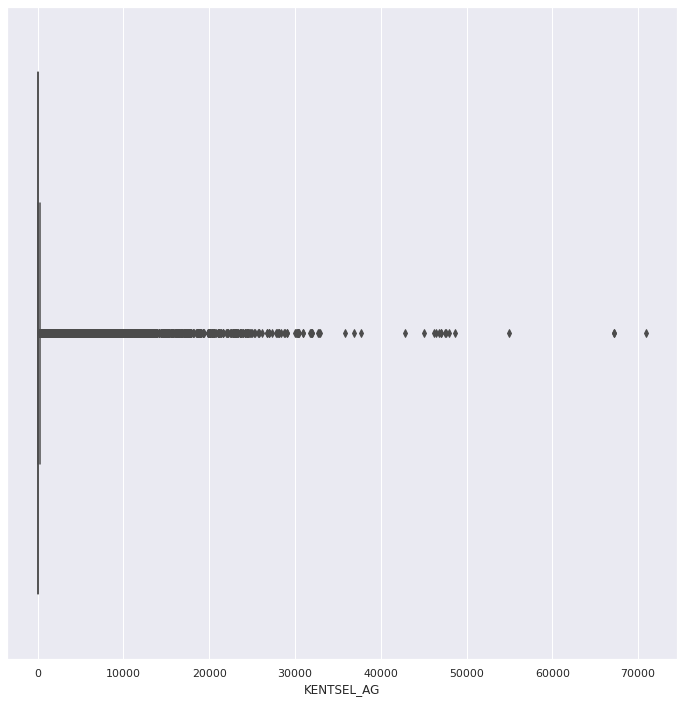

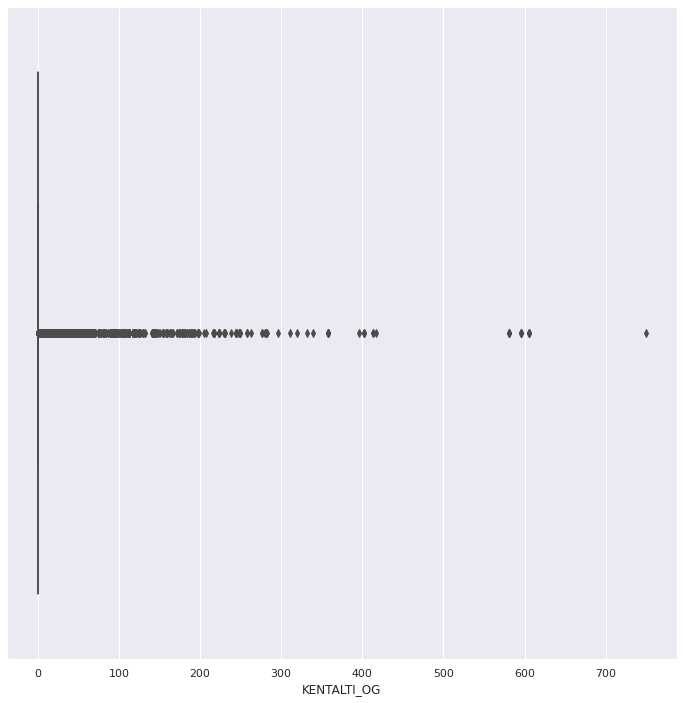

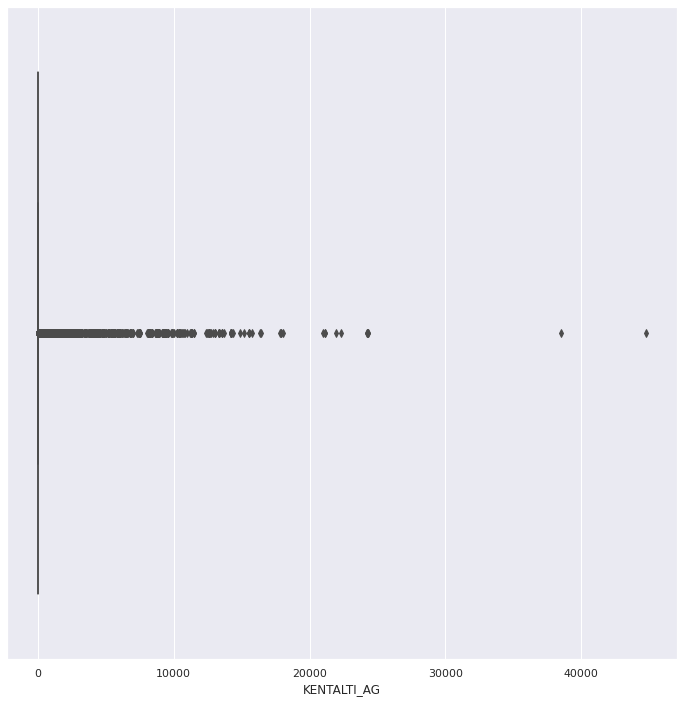

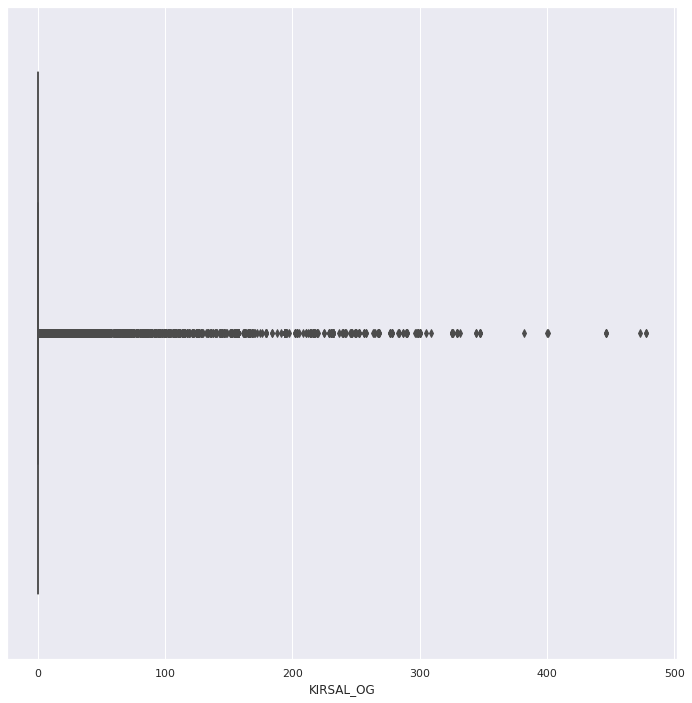

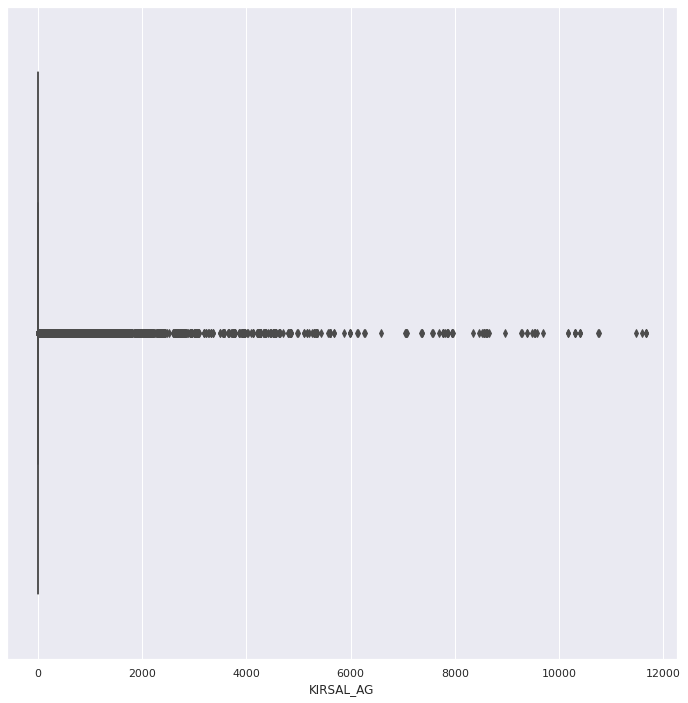

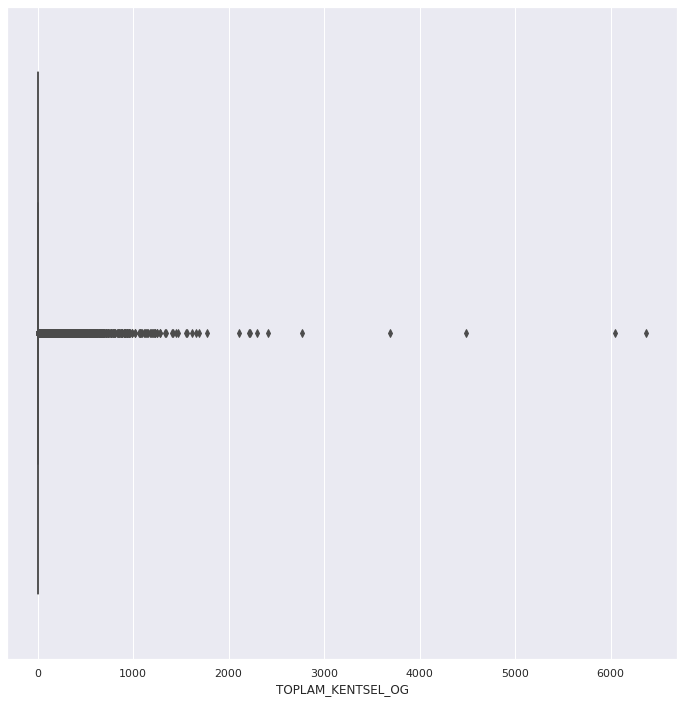

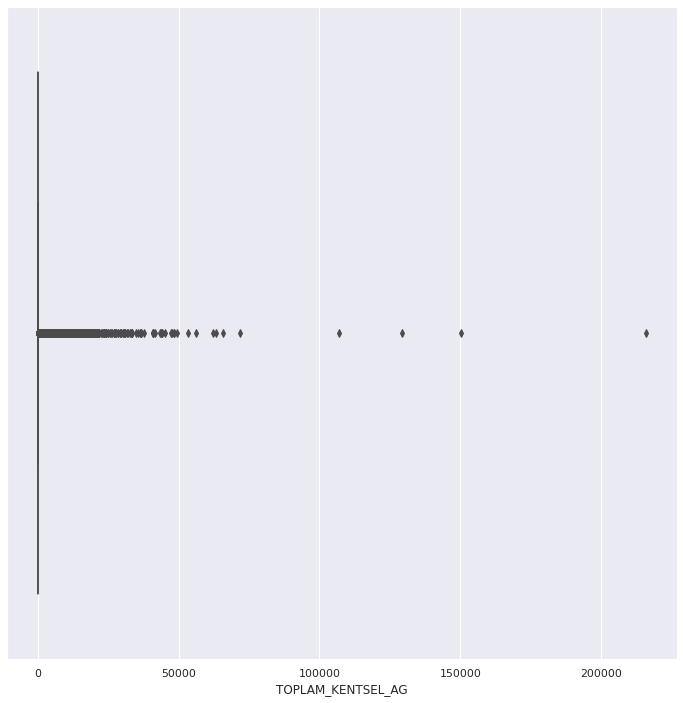

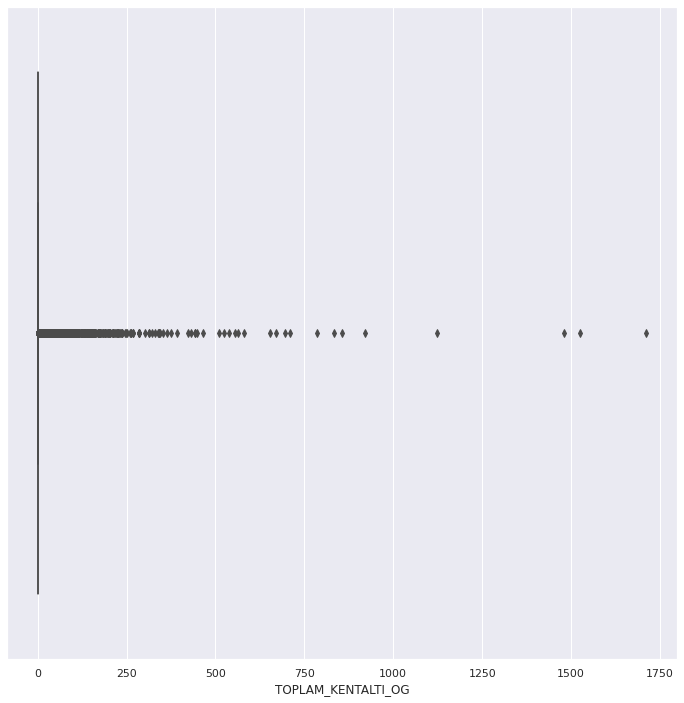

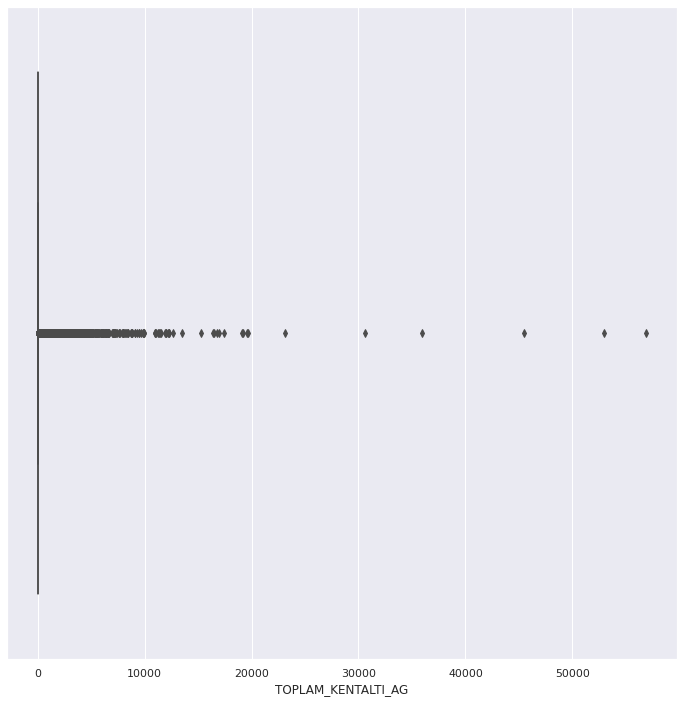

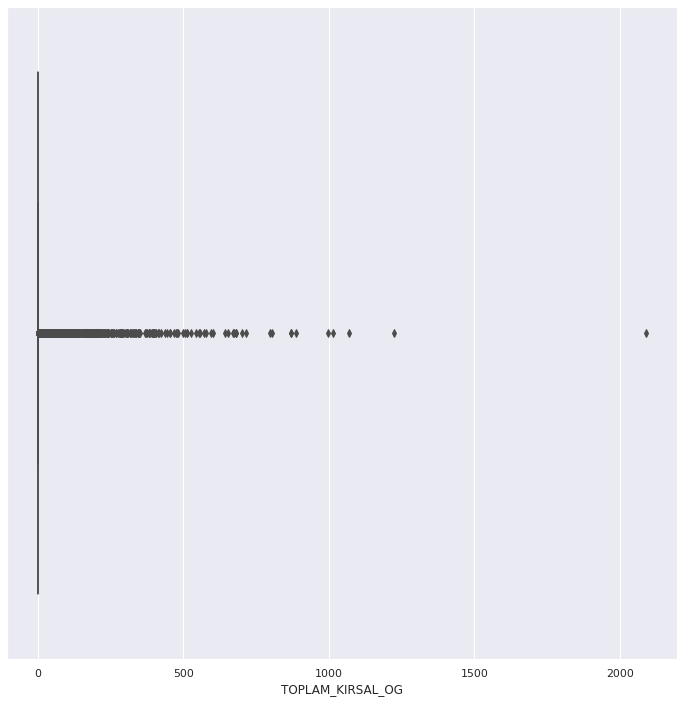

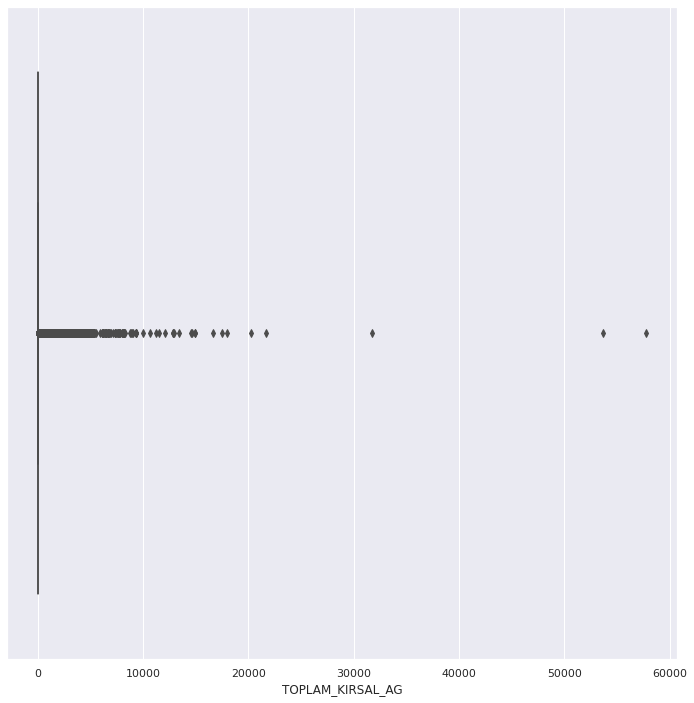

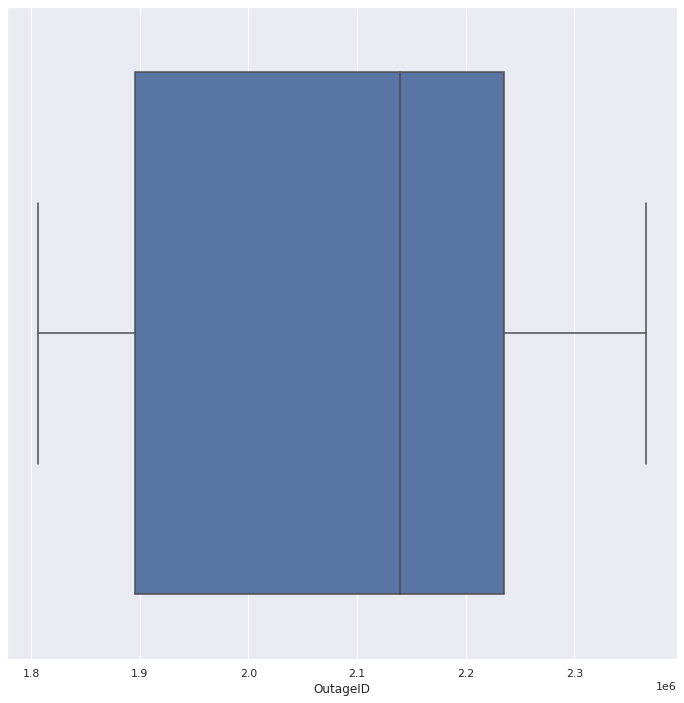

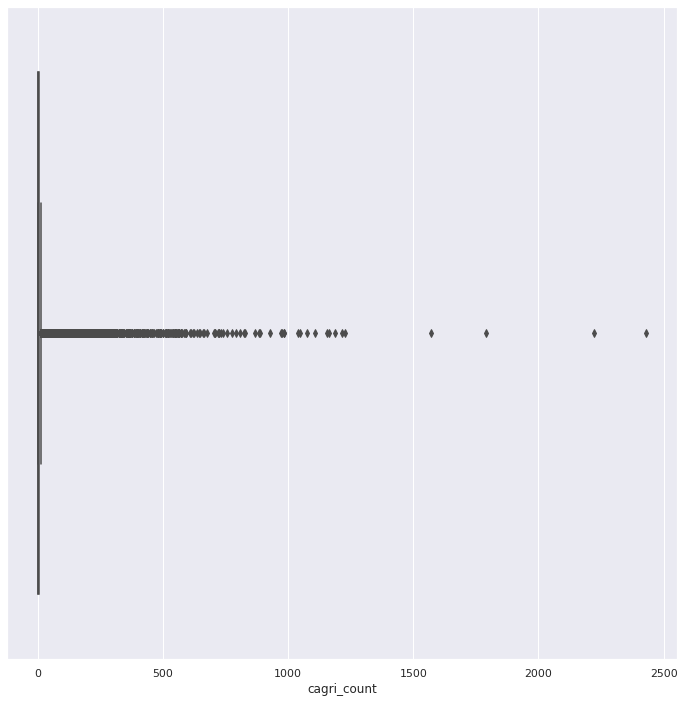

In [350]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

##################### İL ############################
           İL  Ratio
İZMİR   70521 68.330
MANİSA  32686 31.670


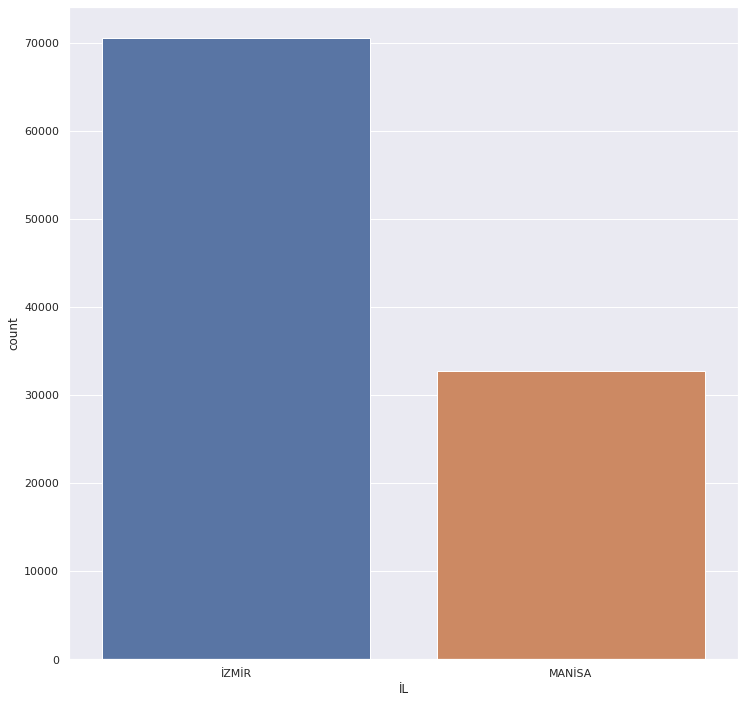

##################### ŞEBEKE_UNSURU ############################
                           ŞEBEKE_UNSURU  Ratio
Abone Tesisi                       33957 32.902
AG Fideri                          25046 24.268
OG Fideri                          11654 11.292
DM                                 10066  9.753
Dağıtım Transformatörü              8369  8.109
KÖK                                 7916  7.670
Saha Dağıtım Kutusu (SDK)           3907  3.786
TM Fideri                           2292  2.221


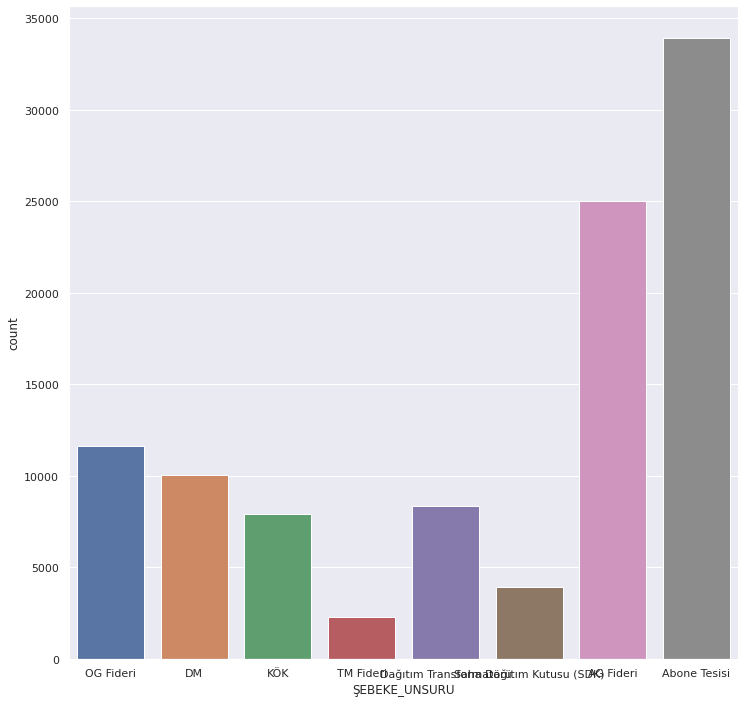

##################### KAYNAĞA_GÖRE ############################
            KAYNAĞA_GÖRE  Ratio
Dağıtım-AG         71282 69.067
Dağıtım-OG         31389 30.414
İletim               536  0.519


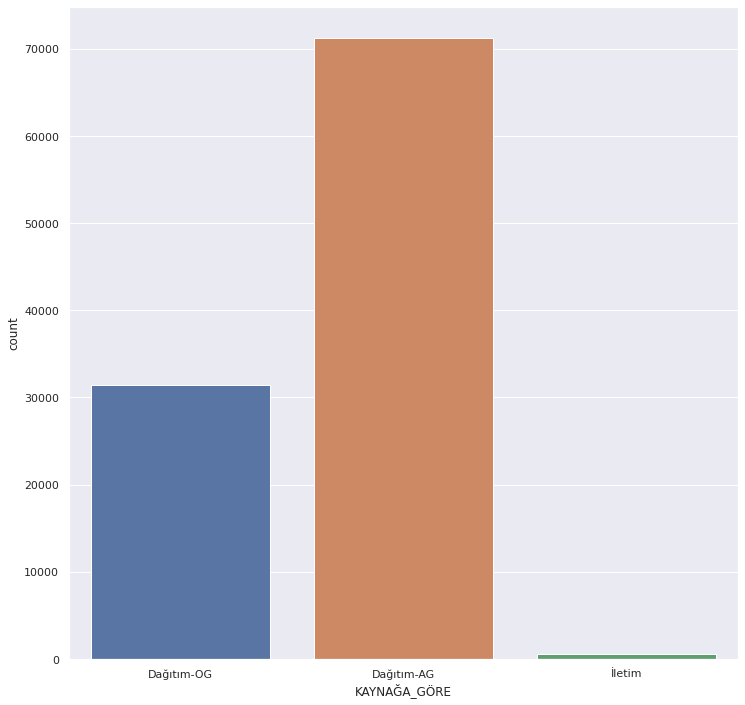

##################### SÜREYE_GÖRE ############################
      SÜREYE_GÖRE  Ratio
Uzun       100309 97.192
Kısa         2898  2.808


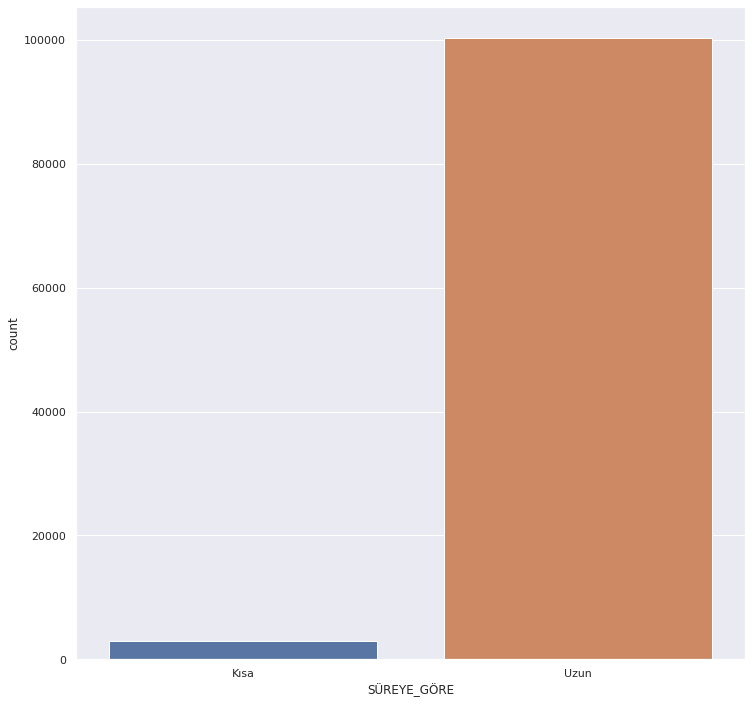

##################### SEBEBE_GÖRE ############################
                    SEBEBE_GÖRE  Ratio
Şebeke işletmecisi       101067 97.926
Dışsal                     2008  1.946
Güvenlik                    131  0.127
0                             1  0.001


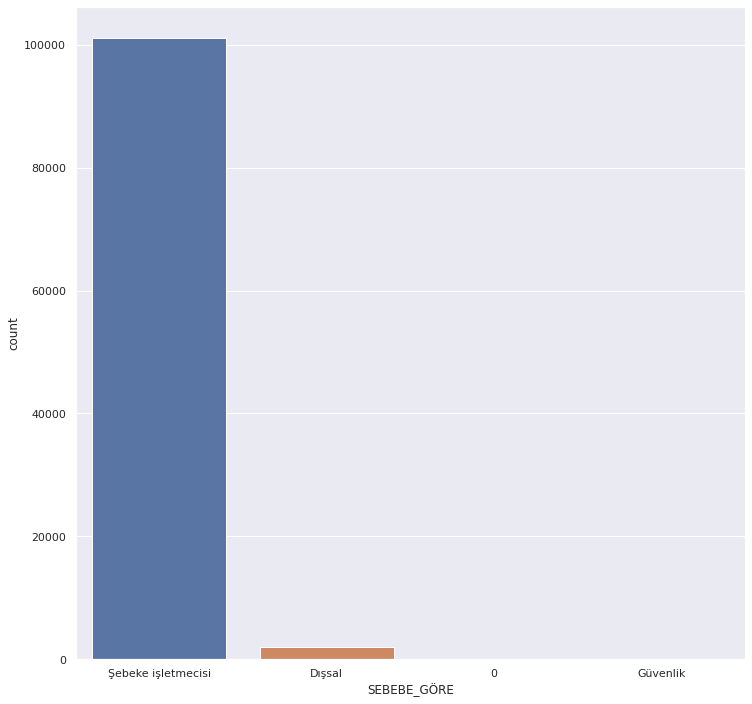

##################### BİLDİRİME_GÖRE ############################
             BİLDİRİME_GÖRE   Ratio
Bildirimsiz          103207 100.000


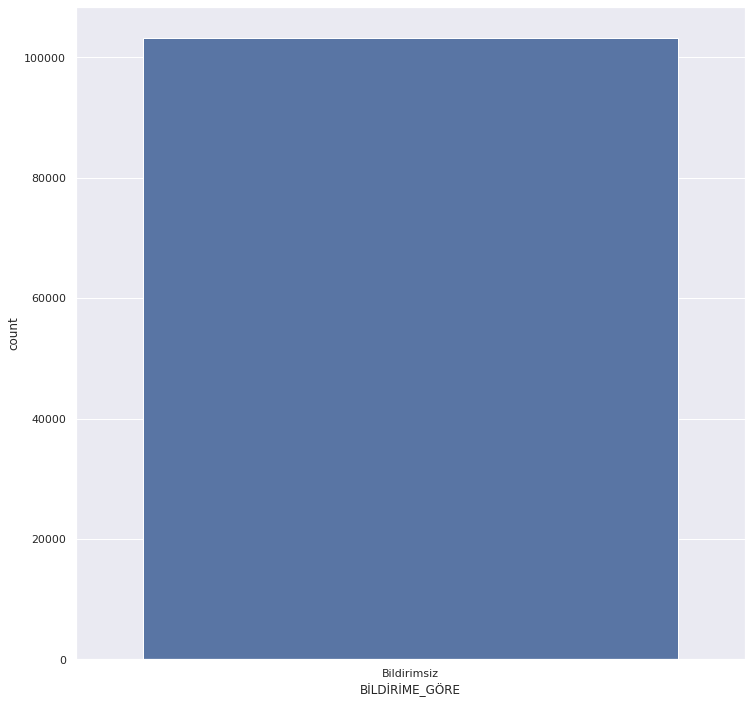

##################### ind ############################
         ind  Ratio
train  86456 83.770
test   16751 16.230


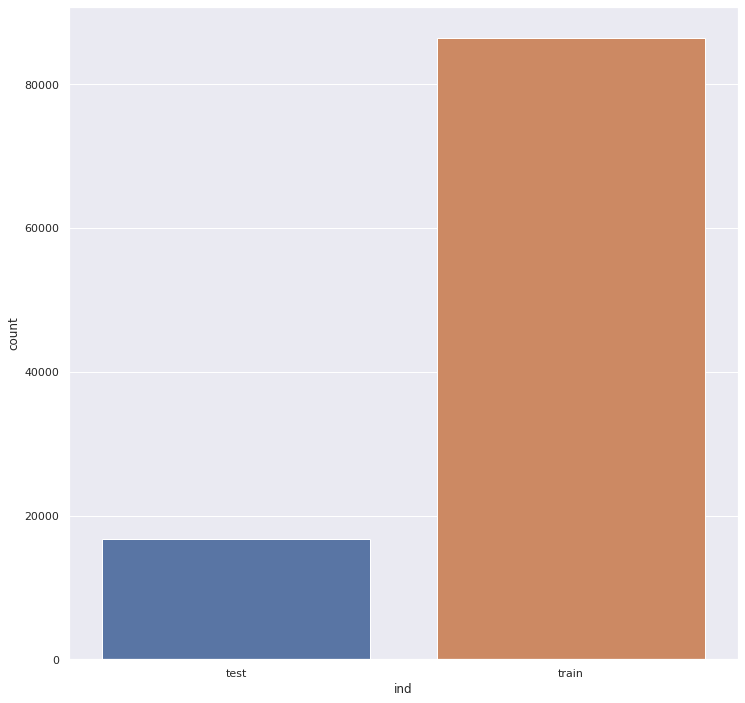

##################### KADEME ############################
       KADEME  Ratio
0.000   86456 83.770
1.000   16751 16.230


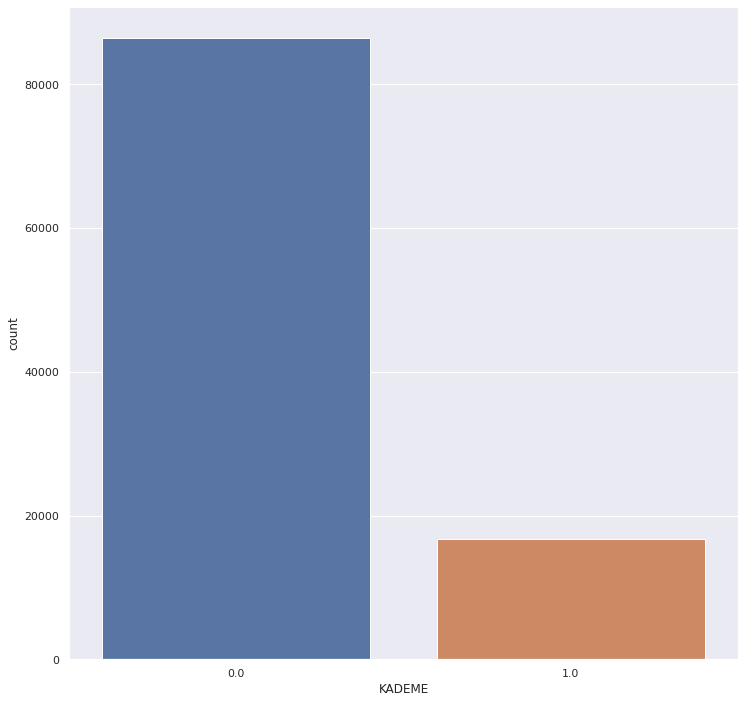

##################### KOD_NO ############################
       KOD_NO  Ratio
0.000   86456 83.770


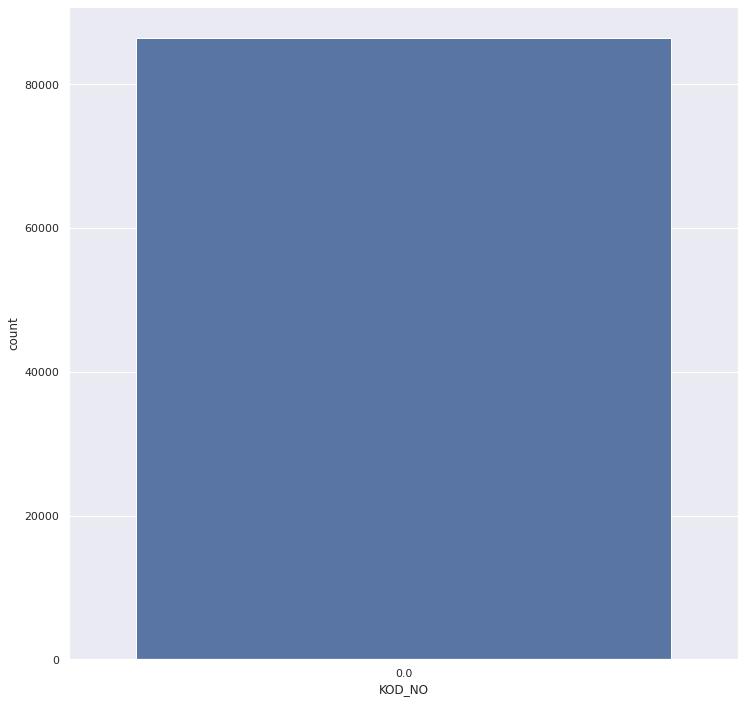

In [351]:
def cat_summary( dataframe, col_name, plot = False):
    print('#####################',col_name,'############################')
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio':100 * dataframe[col_name].value_counts()/len(dataframe)}))

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block = True)

for col in cat_cols:
    cat_summary(df, col, plot = True)

In [352]:
# Target Summary with Categorical Columns:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [353]:
for col in cat_cols:
    target_summary_with_cat(df, 'cagri_count', col)

        TARGET_MEAN
İL                 
MANİSA        6.544
İZMİR         9.810


                           TARGET_MEAN
ŞEBEKE_UNSURU                         
AG Fideri                        6.816
Abone Tesisi                     1.575
DM                              18.935
Dağıtım Transformatörü          10.028
KÖK                             10.262
OG Fideri                       15.569
Saha Dağıtım Kutusu (SDK)        9.045
TM Fideri                       54.884


              TARGET_MEAN
KAYNAĞA_GÖRE             
Dağıtım-AG          4.769
Dağıtım-OG         17.793
İletim             40.807


             TARGET_MEAN
SÜREYE_GÖRE             
Kısa               0.037
Uzun               9.056


                    TARGET_MEAN
SEBEBE_GÖRE                    
0                           NaN
Dışsal                   29.985
Güvenlik                 52.193
Şebeke işletmecisi        8.330


                TARGET_MEAN
BİLDİRİME_GÖRE             
Bildirimsiz           8.788


       TARGE

In [354]:
target_summary_with_cat(df, 'cagri_count', 'KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA')

                                            TARGET_MEAN
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA                      
AG Atlama Kopuğu                                  6.370
AG Box / Sdk Abone Çıkış Faz Sigorta Atığı        1.819
AG Box / Sdk Abone Çıkış Sigorta Atığı            1.978
AG Box / Sdk Giriş Faz Sigorta Atığı              5.390
AG Box / Sdk Giriş Sigorta Atığı                  7.478
AG Box Arızası                                    3.111
AG Branşman Yeraltı Kablo Arızası                 1.941
AG Direk Değişimi                                 3.291
AG Direk Kırılması                                5.250
AG Direkten Kesme Açma                            3.374
AG Hatta Ağaç Kesimi                              2.656
AG Hatta Yabancı Cisim                            6.814
AG Havai Branşman Arızası                         1.262
AG Kablo Başlığı Arızası                          8.235
AG Kademe Ayarı                                   2.156
AG Klemens Arızası                              

In [355]:
target_summary_with_cat(df, 'cagri_count', 'İLÇE')

             TARGET_MEAN
İLÇE                    
AHMETLİ            2.745
AKHİSAR            5.802
ALAŞEHİR           4.398
ALİAĞA             9.927
BALÇOVA           16.123
BAYINDIR           3.610
BAYRAKLI          22.913
BERGAMA            4.334
BEYDAĞ             1.811
BORNOVA           18.086
BUCA              14.510
DEMİRCİ            2.184
DİKİLİ             7.008
FOÇA               9.394
GAZİEMİR          19.233
GÖLMARMARA         2.616
GÖRDES             2.435
GÜZELBAHÇE        12.103
KARABAĞLAR        16.813
KARABURUN          3.639
KARŞIYAKA         16.179
KEMALPAŞA          7.309
KINIK              1.831
KIRKAĞAÇ           5.400
KONAK             13.066
KULA               3.130
KÖPRÜBAŞI          1.743
KİRAZ              3.687
MENDERES           6.749
MENEMEN           12.988
NARLIDERE         18.704
SALİHLİ            6.118
SARIGÖL            2.696
SARUHANLI          3.472
SEFERİHİSAR        5.414
SELENDİ            3.219
SELÇUK             4.268
SOMA               7.468


In [356]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}))


#for col in num_cols:
    #target_summary_with_num(df, 'cagri_count', col)

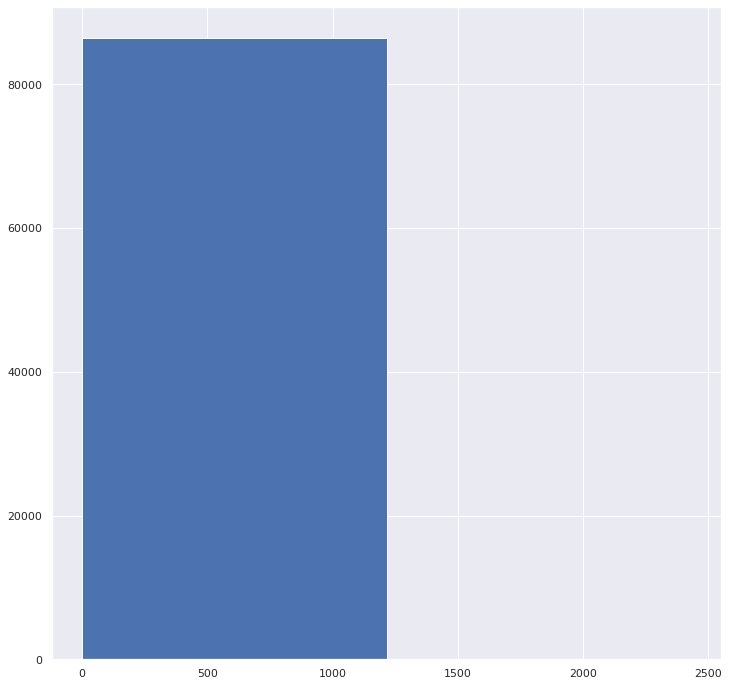

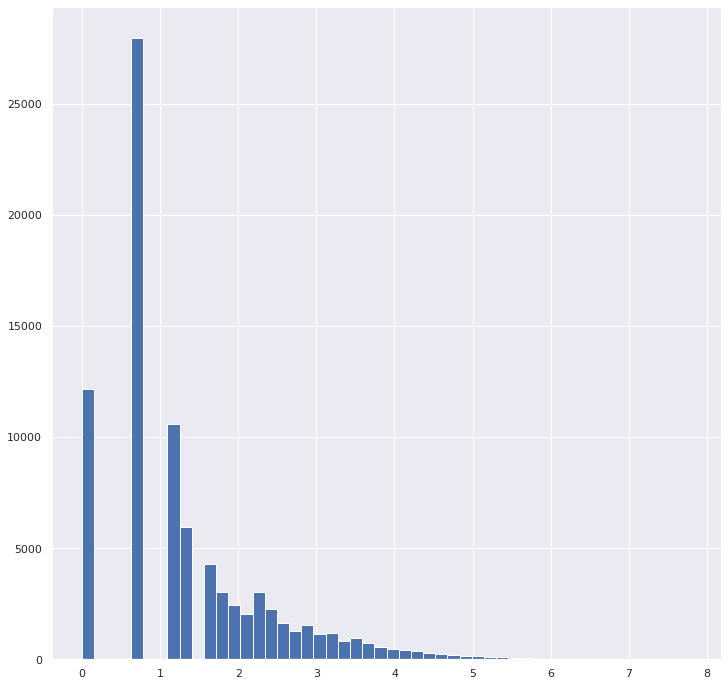

In [357]:
# Bağımlı değişkenin incelenmesi
df["cagri_count"].hist(bins=2)
plt.show()

# Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df['cagri_count']).hist(bins=50)
plt.show()

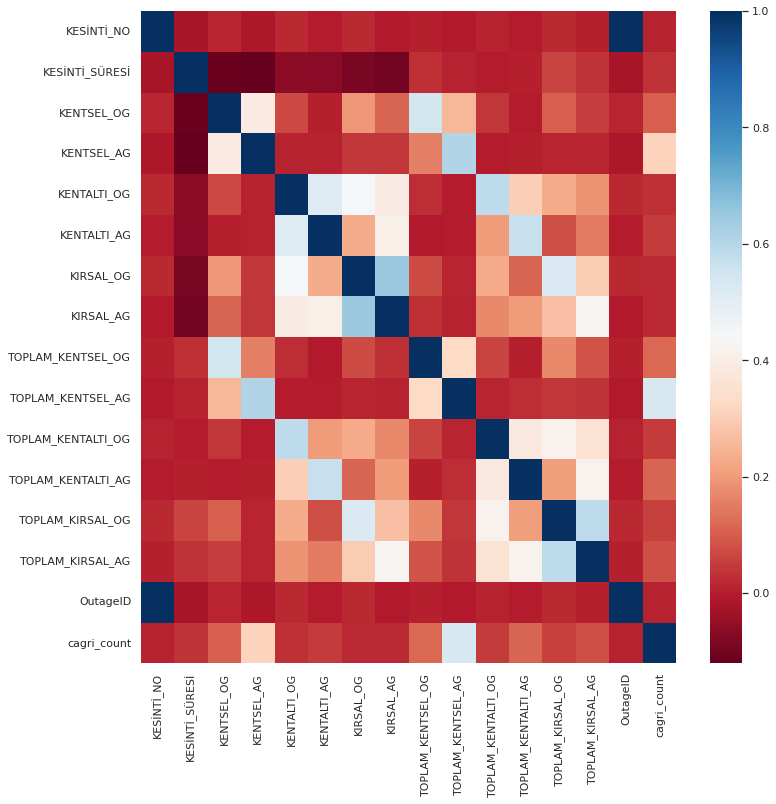

In [358]:
corr = df[num_cols].corr()
corr

# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()

In [359]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


high_correlated_cols(df, plot=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


['OutageID']

In [360]:
df = df.drop('OutageID', axis=1)

In [361]:
df.corr()

,KESİNTİ_NO,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KADEME,KOD_NO,cagri_count
KESİNTİ_NO,1.000,-0.022,0.011,-0.014,0.019,-0.001,0.019,-0.005,0.006,-0.006,0.010,-0.001,0.015,0.005,0.605,NaN,0.007
KESİNTİ_SÜRESİ,-0.022,1.000,-0.112,-0.120,-0.062,-0.066,-0.093,-0.102,0.030,0.007,0.002,0.006,0.063,0.034,-0.061,NaN,0.037
KENTSEL_OG,0.011,-0.112,1.000,0.388,0.072,0.006,0.195,0.116,0.548,0.252,0.040,0.001,0.105,0.053,0.030,NaN,0.107
KENTSEL_AG,-0.014,-0.120,0.388,1.000,0.009,0.008,0.043,0.039,0.159,0.607,0.001,0.005,0.013,0.011,0.005,NaN,0.312
KENTALTI_OG,0.019,-0.062,0.072,0.009,1.000,0.511,0.447,0.395,0.028,-0.001,0.588,0.302,0.233,0.190,0.022,NaN,0.029
KENTALTI_AG,-0.001,-0.066,0.006,0.008,0.511,1.000,0.230,0.408,-0.003,0.000,0.200,0.570,0.077,0.148,0.007,NaN,0.048
KIRSAL_OG,0.019,-0.093,0.195,0.043,0.447,0.230,1.000,0.646,0.075,0.011,0.229,0.115,0.527,0.296,0.023,NaN,0.021
KIRSAL_AG,-0.005,-0.102,0.116,0.039,0.395,0.408,0.646,1.000,0.031,0.007,0.171,0.202,0.272,0.428,0.008,NaN,0.023
TOPLAM_KENTSEL_OG,0.006,0.030,0.548,0.159,0.028,-0.003,0.075,0.031,1.000,0.328,0.063,0.007,0.172,0.088,0.014,NaN,0.119
TOPLAM_KENTSEL_AG,-0.006,0.007,0.252,0.607,-0.001,0.000,0.011,0.007,0.328,1.000,0.013,0.028,0.037,0.036,0.007,NaN,0.532


In [362]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

             n_miss  ratio
KOD_NO        16751 16.230
cagri_count   16751 16.230


This is the NaN value of the target variable(cagri_count) in the test set.

In [363]:
######################################
# Feature Engineering:
######################################

# 1. Date Transformation:

df.BAŞLAMA_TARİHİ_VE_ZAMANI=pd.to_datetime(df.BAŞLAMA_TARİHİ_VE_ZAMANI,dayfirst=True)
df.SONA_ERME_TARİHİ_VE_ZAMANI=pd.to_datetime(df.SONA_ERME_TARİHİ_VE_ZAMANI,dayfirst=True)


df['baslangic_month']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.month
df['sona_erme_month']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.month

df['baslangic_quarter']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.quarter
df['sona_erme_quarter']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.quarter

df['baslangic_day']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.day
df['sona_erme_day']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.day

df['baslangic_dayofweek']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.dayofweek
df['sona_erme_dayofweek']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.dayofweek


df['hour'] = df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.hour
df['son_hour'] = df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.hour

In [364]:
def encode_hours(df, column):
    df.loc[(df[column] > 15) & (df[column] < 24), column+"_dilimi"] = "eglence"
    df.loc[(df[column] > 0) & (df[column] < 9), column+"_dilimi"] = "uyku"
    df[column+"_dilimi"] = df[column+"_dilimi"].fillna("is") 
    return df

df = encode_hours(df, "hour")
df = encode_hours(df, "son_hour")

In [365]:
df['week_of_year_Bas'] = df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.weekofyear
#df['week_of_year_Son'] = df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.weekofyear

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [366]:
df['month_difference'] = df['sona_erme_month'] - df['baslangic_month']
df['quarter_difference'] = df['sona_erme_quarter'] - df['baslangic_quarter']
df['day_difference'] = df['sona_erme_day'] - df['baslangic_day']
df['dayofweek_difference'] = df['sona_erme_dayofweek'] - df['baslangic_dayofweek']

In [367]:
from unidecode import unidecode
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

df['İL']=df['İL'].apply(unidecode).str.lower()
df['İLÇE']=df['İLÇE'].apply(unidecode).str.lower()

df=pd.merge(df,ilce_nufus,on=['İLÇE'],how='left')
df['ilce_nufus'] = df['ilce_nufus'].astype(float)
df['Nufus'] = pd.cut(x = df['ilce_nufus'], bins = [0, 57000, 170000, 348000, 525000], labels = ['Low', 'Moderate', 'High', 'Extreme'])

In [368]:
#df['Nufus_Kesinti'] = df['ilce_nufus'] * df['KESİNTİ_SÜRESİ']  
#df['Nufus_AG'] =  (df['ilce_nufus'] /df['TOPLAM_KENTSEL_AG']) * df['KESİNTİ_SÜRESİ']
#df['Nufus_OG'] =  (df['ilce_nufus'] /df['TOPLAM_KENTSEL_OG']) * df['KESİNTİ_SÜRESİ']

In [369]:
# YENI FEATURE AFTER 30.46. 30.46 ilcin bir onceki notebook a /365 ekledim

In [370]:
#ilce_kesinti_sayisi = df.groupby('İLÇE').agg(ilce_kesinti_sayi = ('KESİNTİ_SÜRESİ', 'count'))
#ilce_kesinti_sayisi.head()

#df=pd.merge(df,ilce_kesinti_sayisi,on=['İLÇE'],how='left')

In [371]:
#df['ilce_kesinti_sayi'].head()

In [372]:
## YENI FEATURE
#ilce_kesinti_sure_top = df.groupby('İLÇE').agg(ilce_kesinti_sure_toplam = ('KESİNTİ_SÜRESİ', 'sum'))
#ilce_kesinti_sure_top.head()


#df=pd.merge(df,ilce_kesinti_sure_top,on=['İLÇE'],how='left')

#df['Oran_kesinti_sure_ilce'] = df['KESİNTİ_SÜRESİ']/(df['ilce_kesinti_sure_toplam']/df['ilce_kesinti_sayi'])

#df['Ortalama_kesinti_sure_ilce'] = df['ilce_kesinti_sure_toplam']/df['ilce_kesinti_sayi']

In [373]:
# Yeni Feature
#df['a']= df['ilce_kesinti_sayi']/ df['KENTSEL_AG']

In [374]:
# Saatlerin gruplandirilmasi
df['HOURS_NEW'] = pd.cut(x = df['hour'], bins = [0, 6, 12, 18, 24], labels = ['Early', 'Morning', 'Midday', 'Night'])

In [375]:
# Nufus az-orta-cok-extreme diye gruplandirilmisti. Bunu kesinti saati erken-sabah-gunortasi-gece olarak birlestirdim.
df['NUFUS_HOURS_NEW'] = df['Nufus'].astype(str) + df['HOURS_NEW'].astype(str)

In [376]:
# Kesinti suresi negatif degerliydi. Pozitife cevirdim.
df["KESİNTİ_SÜRESİ"] = df["KESİNTİ_SÜRESİ"].abs()

In [377]:
# Saat cinsinden ifade edilen kesinti suresinden KENTTEKI ALCAK gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_AG'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KENTSEL_AG']/365
# Saat cinsinden ifade edilen kesinti suresinden KENTTEKI ORTA gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_OG'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KENTSEL_OG']/365
# Saat cinsinden ifade edilen kesinti suresinden KIRSALDAKI ORTA gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_K_OG'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KIRSAL_OG']/365
# Saat cinsinden ifade edilen kesinti suresinden KIRSALDAKI ALCAK gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_K_AG'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KIRSAL_AG']/365
# Saat cinsinden ifade edilen kesinti suresinden KENTALTI ALCAK gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_AG_2'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KENTALTI_AG']/365
# Saat cinsinden ifade edilen kesinti suresinden KENTALTI ORTA gerilimli hatlardaki gunluk ortalama kesinti suresini cikardim.
df['NEW_OG_2'] = df['KESİNTİ_SÜRESİ']-df['TOPLAM_KENTALTI_OG']/365
# KENTTEKI TOPLAM ALCAK VE ORTA GERILIM HAT SAYISINI, KESINTI SURESI ILE CARPTIM.
df['NEW_KENTSEL'] = (df['KENTSEL_AG'] + df['KENTSEL_OG'])/df['KESİNTİ_SÜRESİ']
# KENTALTINDAKI TOPLAM ALCAK VE ORTA GERILIM HAT SAYISINI, KESINTI SURESI ILE CARPTIM.
df['NEW_KENTALTI'] = (df['KENTALTI_AG'] + df['KENTALTI_OG'])/df['KESİNTİ_SÜRESİ']
# KIRSALDAKI TOPLAM ALCAK VE ORTA GERILIM HAT SAYISINI, KESINTI SURESI ILE CARPTIM.
df['NEW_KIRSAL'] = (df['KIRSAL_AG'] + df['KIRSAL_OG'])/df['KESİNTİ_SÜRESİ']
# ALCAK GERILIMLI HATLARDAKI YIL ICINDE YASANAN TOPLAM KESINTI SAYISINI BULUP, 365 E BOLDUM. ORTALAMA ALCAK GERILIMLI HATTA CIKAN KESINTI SURESINI VERDI.
df['TOPLAM_AG'] = (df['TOPLAM_KENTSEL_AG']+ df['TOPLAM_KIRSAL_AG']+df['TOPLAM_KENTALTI_AG'])/365
# ORTA GERILIMLI HATLARDAKI YIL ICINDE YASANAN TOPLAM KESINTI SAYISINI BULUP, 365 E BOLDUM. ORTALAMA ORTA GERILIMLI HATTA CIKAN KESINTI SURESINI VERDI.
df['TOPLAM_OG'] = (df['TOPLAM_KENTSEL_OG']+df['TOPLAM_KIRSAL_OG']+df['TOPLAM_KENTALTI_OG'])/365

df['TOPLAM_HAT_SAYISI'] = df['KENTSEL_AG']+df['KENTSEL_OG']+df['KENTALTI_AG']+df['KENTALTI_OG']+df['KIRSAL_AG']+df['KIRSAL_OG']

In [378]:
#df['TOPLAM_HAT_SAYISI_NUFUS'] = df['ilce_nufus'] / df['TOPLAM_HAT_SAYISI']

In [379]:
# IZMIR ICIN SEHRIN ICINDEKI ILCELERI YAKIN, SEHRE UZAK ILCELERE UZAK YAPISTIRDIM.
df['UZAKLIK'] = df['İLÇE'].apply(lambda x: 'UZAK' if x not in ['BORNOVA', 'KONAK','BUCA', 'KARABAĞLAR', 'KARŞIYAKA', 'BAYRAKLI', 'GAZIEMIR', 'NARLIDERE', 'BALÇOVA'] else 'YAKIN' )
# BU UZAKLIK YAKINLIGI SAYI ILE IFADE ETTIM.
df['UZAKLIK_SAYI']= df['UZAKLIK'].apply(lambda x: 2 if 'UZAK' else 1)
df['UZAK_HOUR'] = df['UZAKLIK'].apply(lambda x: 2 if 'UZAK' else 1)*df['hour']

In [380]:
#ILCE NUFUSUNU NEW KENTSELE BOLDUM DE BUNU NIYE YAPTIM??
df['NUFUS_KENTSEL_NEW'] = df['ilce_nufus']*(df['NEW_KENTSEL'])

In [381]:
# ILCE NUFUSUNU TOPLAM ALCAK VE ORTA GERILIMLI HAT SAYISINA BOLDUM
df['NUFUS_KENTSEL_AGOG'] = df['ilce_nufus']*(df['KENTSEL_AG'] + df['KENTSEL_OG'])
df['NUFUS_KENTALTI_AGOG'] = df['ilce_nufus']*(df['KENTALTI_AG'] + df['KENTALTI_OG'])
df['NUFUS_KIRSAL_AGOG'] = df['ilce_nufus']*(df['KIRSAL_AG'] + df['KIRSAL_OG'])

In [382]:
# ILCE NUFUSNU KENTTEKI ALCAK GERLIMLI HAT SAYISINA BOLUP , KENTTEKI ALCAK GERILIMLI HAT SAYISINDA CIKAN TOPLAM KESINTI MIKTARI ILE CARPTIM.
df['AG_TOPLAM_KENTSEL'] = (df['ilce_nufus'] / df['KENTSEL_AG'])*df['TOPLAM_KENTSEL_AG']

In [383]:
# ILCE NUFUSUNU KENTTEKI ORTA VE ALCAK GERILIMLI HATLARDA YASANAN TOPLEM KESINTI SAYISINA BOLDUM. KISI BASI KESINTI SAYISI GIBI BIR SEY CIKTI, 
# CIKAN SONUCU ILCENIN KENTE UZAKLIGI ILE CARPTIM.
df['NUFUS_UZAKLIK'] = df['ilce_nufus']*(df['TOPLAM_AG']+df['TOPLAM_OG'])*df['UZAK_HOUR'].astype(int)

In [384]:
# KESINTI SURESINI KATEGORILERE AYIRDIM.
df['KESINTI_NEW'] = pd.cut(x = df['KESİNTİ_SÜRESİ'], bins = [-1,3,10,30,100000],
                               labels = ['Low','Normal', 'Extreme', 'XXXextreme'])

In [385]:
# KATEGORILERE AYRILAN KESINTI SURESINI SAAT KATEGORILERI ILE BIRLESTIRDIM.
df['KESINTI_HOUR'] = df['KESINTI_NEW'].astype(str) + df['HOURS_NEW'].astype(str)

In [386]:
# TR ile baslayan sebek unsuru kodlarini aldim.
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.startswith('TR', na=False),'SEBEKE_STARTSWITH'] = 'TR'

In [387]:
# DM ile baslayan sebeke unsuru kodlarini aldim
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.startswith('DM', na=False),'SEBEKE_STARTSWITH'] = 'DM'

In [388]:
# TRAFO iceren sebeke kodlarini aldim.
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('DIREK TIPI TRAFO HUCRESI'),'SEBEKE_TRAFO'] = 'TRAFO'

In [389]:
# Petrol iceren sebeke unsuru kodlarini aldim.
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('PETROL'),'SEBEKE_PETROL'] = 'PETROL'

In [390]:
# TARIM ve turevi iceren sebeke kodlarini aldim.
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('TARIM' or 'TARIMSAL' or 'SULAMA' or'TOPRAK'or 'SLM'),'SEBEKE_TARIM'] = 'TARIM'

In [391]:
# Koy icerenler
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('KÖY'),'SEBEKE_KOY'] = 'KOY'
# OZEL icerenler
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('ÖZEL'),'SEBEKE_OZEL'] = 'ÖZEL'
# Telco ismi iceren sebek kodlarini aldim
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('TURKCELL' or 'TÜRK TELEKOM' or 'VODAFONE'),'SEBEKE_TELCO'] = 'TELCO'
# Industry iceren sebeke kodlarini aldim.
df.loc[df['ŞEBEKE_UNSURU_KODU'].str.contains('FABRİKA' or 'SANAYİ' or 'ORGANİZE'),'SEBEKE_INDUSTRY'] = 'INDUSTRY'

In [392]:
# olusturulan degiskenler icin kalan kisimlar nan olacagi icin nan'leri other yaptim.
df['SEBEKE_STARTSWITH'].fillna('Other',inplace = True)
df['SEBEKE_TRAFO'].fillna('Other',inplace = True)
df['SEBEKE_PETROL'].fillna('Other',inplace = True)
df['SEBEKE_TARIM'].fillna('Other',inplace = True)
df['SEBEKE_KOY'].fillna('Other',inplace = True)
df['SEBEKE_OZEL'].fillna('Other',inplace = True)
df['SEBEKE_TELCO'].fillna('Other',inplace = True)
df['SEBEKE_INDUSTRY'].fillna('Other',inplace = True)
#df['SEBEKE_STARTSWITH'].fillna('Other',inplace = True)

In [393]:
# Kademe gereksiz.
df = df.drop('KADEME',axis=1)

In [394]:
# UZAK-YAKIN I KALABALIK-AZ KALABALIK OLARAK BIRLESTIRDIK.
df['UZAKLIKvNUFUS'] = df['UZAKLIK'].astype(str)+df['Nufus'].astype(str)

In [395]:
# KESINTI SURESI ile kesinti SAATINI VE uzakligi carptim. burada saati iki kere carptim, ama bi kere carparsam rmse yuksek cikiyodu :D
df['KESINTI_HOUR'] = df['KESİNTİ_SÜRESİ']*df['hour']*df['UZAK_HOUR']

In [396]:
# ustteki carpima toplam alcak gerilimdeki kesinti suresini ekledim.
df['KESINTI_HOUR_2'] = df['KESİNTİ_SÜRESİ']*df['hour']*df['UZAK_HOUR']*df['TOPLAM_KENTSEL_AG']

In [397]:
# Kategorilere ayrilan kesinti suresi ile uzaklik birlesti
df['KESINTIvUZAKLIK']= df['UZAKLIK'].astype(str)+df['KESINTI_NEW'].astype(str)

In [398]:
#df['UZAK_HOUR'] = df['UZAKLIK'].astype(str) + df['HOURS_NEW'].astype(str)

In [399]:
#df['Feature1']= df['UZAKLIK']+'_'+df['baslangic_month']

In [400]:
df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts()

OG Fider Açması                               20541
AG Havai Branşman Arızası                     17966
AG Pano Kol Sigorta Atığı                     17675
AG Box / Sdk Abone Çıkış Sigorta Atığı         6289
AG Branşman Yeraltı Kablo Arızası              5780
OG Sigorta Atması                              4961
AG Termik Açması                               4917
AG Direkten Kesme Açma                         3482
Üçüncü Şahısların Vermiş Olduğu Hasarlar       3233
AG Tel Kopuğu                                  3150
AG Box / Sdk Giriş Sigorta Atığı               1313
Manevra                                        1289
AG Yeraltı Kablo Arızası                       1097
AG Sehim Bozukluğu                              996
OG Ayırıcı Arızası                              916
AG Atlama Kopuğu                                790
AG Hatta Ağaç Kesimi                            700
AG Klemens Arızası                              672
AG Yük Ayırıcı Arızası                          659
OG İletken K

In [401]:
print(col, ":", len(df['İLÇE'].value_counts()))
print(pd.DataFrame({"COUNT": df['İLÇE'].value_counts(),
                    "RATIO": df['İLÇE'].value_counts() / len(df),
                    "TARGET_MEAN": df.groupby('İLÇE')['cagri_count'].mean()}).sort_values('TARGET_MEAN',ascending = False), end="\n\n\n")

KOD_NO : 47
             COUNT  RATIO  TARGET_MEAN
bayrakli      1801  0.017       22.913
cigli         1722  0.017       21.574
gaziemir       907  0.009       19.233
narlidere      476  0.005       18.704
bornova       3724  0.036       18.086
karabaglar    2392  0.023       16.813
karsiyaka     2197  0.021       16.179
balcova        426  0.004       16.123
buca          2768  0.027       14.510
konak         3497  0.034       13.066
menemen       2855  0.028       12.988
guzelbahce     665  0.006       12.103
urla          3645  0.035       11.867
turgutlu      3018  0.029       11.207
yunusemre     4337  0.042       10.994
aliaga        1909  0.018        9.927
sehzadeler    2966  0.029        9.662
foca          1395  0.014        9.394
torbali       3708  0.036        9.024
soma          1866  0.018        7.468
kemalpasa     2912  0.028        7.309
dikili        2522  0.024        7.008
menderes      3790  0.037        6.749
cesme         5534  0.054        6.361
salihli      

In [402]:
# Burada ilceleri target meanlerine gore grupladim.
df['İLÇE'] = df['İLÇE'].str.upper()
df.loc[df['İLÇE'].str.contains("BAYRAKLI" or 'CIGLI' or 'KARABAGLAR'), "ilce_grup"] = 'BCK'
df.loc[df['İLÇE'].str.contains("GAZİEMİR" or 'KONAK' or 'NARLIDERE'), "ilce_grup"] = 'GKN'
df.loc[df['İLÇE'].str.contains("BORNOVA" or 'KARSIYAKA'), "ilce_grup"] = 'BK'
df.loc[df['İLÇE'].str.contains("FOCA" or 'MENEMEN' or 'ALİAGA' or 'BUCA' or 'YUNUSEMRE' or 'SEHZADELER' or 'URLA' or 'SOMA'),"ilce_grup"] = "FMABYS"
df.loc[df['İLÇE'].str.contains("GUZELBAHCE" or 'TORBALI' or 'BERGAMA' or 'BALCOVA' or 'TURGUTLU' or 'KEMALPASA' or 'MENDERES'), "ilce_grup"] = 'GTBBTKM'
df.loc[df['İLÇE'].str.contains("DIKILI" or 'SARUHANLI' or 'SEFERIHISAR' or 'ALASEHIR' or 'ÇESME' or 'KIRKAGAC' or 'AKHISAR' or 'ODEMIS' or 'KARABURUN' or 'SELCUK' or 'TIRE'), "ilce_grup"] = 'cok'
df.loc[df['İLÇE'].str.contains("SALIHLI" or 'BAYINDIR' or 'AHMETLI' or 'SELENDI'), "ilce_grup"] = 'low2'
df.loc[df['İLÇE'].str.contains("KULA" or 'KIRAZ' or 'GORDES'or 'KINIK' or 'KOPRUBASI' or 'SARIGOL' or 'DEMIRCI' or 'GOLMARMARA' or'BEYDAG '), "ilce_grup"] = "low1"

In [403]:
df['ilce_grup'].value_counts()

BK         3724
low2       3597
cok        2522
BCK        1801
FMABYS     1395
low1       1311
GTBBTKM     665
Name: ilce_grup, dtype: int64

In [404]:
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG Direk Yıkılması'), 'Yuksek Sureli Arizalar'] =  414.835
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG Trafo Arızası' or 'AG Pano Arızası' or 'AG Yeraltı Kablo Arızası' or 'OG İletken Kopması'), 'Yuksek Sureli Arizalar'] = 283
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Direk Kırılması'or 'AG Branşman Yeraltı Kablo Arızası'), 'Yuksek Sureli Arizalar']=240
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('Hırsızlık' or 'OG Travers Arızası' or 'Şebeke Bakım Çalışması'), 'Yuksek Sureli Arizalar'] =230
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG Yeraltı Kablo Arızası ' or 'AG Hatta Yabancı Cisim ' or 'OG İzolatör Arızası '), 'Yuksek Sureli Arizalar' ] =215

df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Tel Kopuğu' or 'Üçüncü Şahısların Vermiş Olduğu Hasarlar' or 'AG Direk Değişimi' or 'AG Pano Faz Sigorta Atığı' or 'AG Atlama Kopuğu  '), 'Yuksek Sureli Arizalar'] =195

df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG Kablo Başlığı Arızası' or 'AG Nötr İletken Kopması' or 'AG Kablo Başlığı Arızası'or 'AG Klemens Arızası' or 'AG Sehim Bozukluğu'), 'Yuksek Sureli Arizalar'] = 176
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Havai Branşman Arızası' or 'AG Box Arızası' or 'OG Atlama Arızası' or 'Yangın' or 'AG İzolatör Arızası' or 'OG Atlama(Jumper) Arızası'), 'Yuksek Sureli Arizalar'] =165
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Pano Kol Sigorta Atığı' or 'OG Sigorta Atması' or 'AG Sigorta Atığı' or 'NH Altlık Arızası'), 'Yuksek Sureli Arizalar'] =155
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Box / Sdk Giriş Sigorta Atığı' or 'OG Klemens Arızası' or 'OG Ayırıcı Arızası' or'AG Termik Açması'), 'Yuksek Sureli Arizalar'] =143
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Box / Sdk Abone Çıkış Faz Sigorta Atığı' or 'AG Box / Sdk Abone Çıkış Sigorta Atığı' or 'Müteahhit Çalışması' or 'OG Kesici Arızası' or 'Trafo Bakım Çalışması' or 'AG Box / Sdk Giriş Faz Sigorta Atığı'), 'Yuksek Sureli Arizalar']=134
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG Direkten Kesme Açma' or 'AG Box / Sdk Abone Çıkış Sigorta Atığı'), 'Yuksek Sureli Arizalar'] =113
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('Fiziki İrtibat' or 'OG Hatta Ağaç Kesimi'), 'Yuksek Sureli Arizalar'] =100
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('Ağaç Kesimi' or 'Yük Aktarımı ' or 'Yangın Sonucu Şebeke Hasarı' or 'Yabani Hayvan Teması' or 'AG Kademe Ayarı' or 'EİH Arızası' or 'TEİAŞ Trafo Arızası'), 'Yuksek Sureli Arizalar'] =72
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG Fider Açması' or 'OG Trafo Kademe Ayarı' or 'OG Fider Açması'), 'Yuksek Sureli Arizalar'] =54.218
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('Manevra' or 'AG Voltaj Düşüklüğü'), 'Yuksek Sureli Arizalar'] =18
df['Yuksek Sureli Arizalar']=df['Yuksek Sureli Arizalar'].fillna(140)
df['Yuksek Sureli Arizalar'] = df['Yuksek Sureli Arizalar'].astype(int)

In [405]:
df['Yuksek Sureli Arizalar'].value_counts()
#df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].unique()

140    35936
54     20541
165    17966
155    17675
113     3482
195     3150
143     1313
18      1289
72       797
283      278
134      244
176      176
230      165
240       93
100       57
414       45
Name: Yuksek Sureli Arizalar, dtype: int64

In [406]:
df['a'] = df['Yuksek Sureli Arizalar']*df['hour']*df['UZAKLIK_SAYI'].astype(int)

In [407]:
print(col, ":", len(df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts()))
print(pd.DataFrame({"COUNT": df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts(),
                    "RATIO": df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts() / len(df),
                    "TARGET_MEAN": df.groupby('KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA' )['KESİNTİ_SÜRESİ'].mean()}).sort_values('TARGET_MEAN',ascending = False), end="\n\n\n")

KOD_NO : 64
                                            COUNT  RATIO  TARGET_MEAN
OG Direk Yıkılması                             45  0.000        6.914
OG Trafo Arızası                              278  0.003        4.949
AG Pano Arızası                               129  0.001        4.933
AG Yeraltı Kablo Arızası                     1097  0.011        4.750
OG İletken Kopması                            412  0.004        4.625
AG Direk Kırılması                             93  0.001        4.134
AG Branşman Yeraltı Kablo Arızası            5780  0.056        3.921
Hırsızlık                                     165  0.002        3.906
OG Travers Arızası                             11  0.000        3.864
Şebeke Bakım Çalışması                          9  0.000        3.831
OG Yeraltı Kablo Arızası                      365  0.004        3.666
AG Hatta Yabancı Cisim                        274  0.003        3.584
OG İzolatör Arızası                           195  0.002        3.445
AG Tel K

In [408]:
print(col, ":", len(df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts()))
print(pd.DataFrame({"COUNT": df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts(),
                    "RATIO": df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts() / len(df),
                    "TARGET_MEAN": df.groupby('KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA' )['KESİNTİ_SÜRESİ'].mean()}).sort_values('TARGET_MEAN',ascending = False), end="\n\n\n")

KOD_NO : 64
                                            COUNT  RATIO  TARGET_MEAN
OG Direk Yıkılması                             45  0.000        6.914
OG Trafo Arızası                              278  0.003        4.949
AG Pano Arızası                               129  0.001        4.933
AG Yeraltı Kablo Arızası                     1097  0.011        4.750
OG İletken Kopması                            412  0.004        4.625
AG Direk Kırılması                             93  0.001        4.134
AG Branşman Yeraltı Kablo Arızası            5780  0.056        3.921
Hırsızlık                                     165  0.002        3.906
OG Travers Arızası                             11  0.000        3.864
Şebeke Bakım Çalışması                          9  0.000        3.831
OG Yeraltı Kablo Arızası                      365  0.004        3.666
AG Hatta Yabancı Cisim                        274  0.003        3.584
OG İzolatör Arızası                           195  0.002        3.445
AG Tel K

In [409]:
# Kesinti nedeninden Ag ve Og yi cikarttim yeni degisken elde ettim.
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('AG'),'KESINTI_NEDENI'] = 'AG'
df.loc[df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].str.contains('OG'),'KESINTI_NEDENI'] = 'OG'

In [410]:
df['KESINTI_NEDENI']=df['KESINTI_NEDENI'].fillna('Other')

In [411]:
# Kesinti nedeni ile  nufus yogunlugunu string olarak grupladim
df['NufusvKesintiNeden'] = df['KESINTI_NEDENI'].astype(str) + df['Nufus'].astype(str)

In [412]:
df['KESINTI_NEDENI'].value_counts()

AG       67873
OG       29256
Other     6078
Name: KESINTI_NEDENI, dtype: int64

In [413]:
# Kesinti nedenine iliskin aciklamalari target mean lerine gore grupladim.
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["Şebeke Bakım Çalışması", "EİH Arızası", "Yangın Sonucu Şebeke Hasarı", 
                                                                'Müteahhit Çalışması', 'OG Trafo Kademe Ayarı', 'Trafo Bakım Çalışması',
                                                                'OG Travers Arızası', 'TEİAŞ Hat Bakım Çalışması']), 1 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Direk Kırılması", "AG Voltaj Düşüklüğü" , "AG Box / Sdk Abone Çıkış Faz Sigorta Atığı",
                                                                                              "AG Hatta Ağaç Kesimi", "AG Havai Branşman Arızası",  "AG Direk Değişimi" ,'AG Travers Arızası']), 2 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Kademe Ayarı", "AG Branşman Yeraltı Kablo Arızası" , "AG Box / Sdk Abone Çıkış Sigorta Atığı",
                                                                                              "OG Kademe Ayarı", "AG Nötr İletken Kopması",  "AG Sehim Bozukluğu" , 'AG Box Arızası', 'AG İzolatör Arızası']), 3 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Direkten Kesme Açma", "AG Voltaj Düşüklüğü" , "AG Box / Sdk Abone Çıkış Faz Sigorta Atığı",
                                                                                              "AG Hatta Ağaç Kesimi", "AG Havai Branşman Arızası",  "AG Direk Değişimi" ,'AG Travers Arızası']),  4 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Box / Sdk Giriş Faz Sigorta Atığı", "Manevra" , "AG Kablo Başlığı Arızası",
                                                                                              "OG Sigorta Atması" , 'AG Tel Kopuğu']),  5, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Atlama Kopuğu", "AG Pano Kol Sigorta Atığı" , "OG Ayırıcı Arızası",
                                                                                              "OG Hatta Ağaç Kesimi"]), 6 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Pano Faz Sigorta Atığı", "Yük Aktarımı" , "Hırsızlık",
                                                                                              "AG Box / Sdk Giriş Sigorta Atığı", "AG Termik Açması" ]),  7 , df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])                                                                                              

In [414]:
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["TEİAŞ Trafo Arızası", "Yabani Hayvan Teması" ]), 15, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Pano Arızası", "OG Yeraltı Kablo Arızası" ]), 14, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["OG Kesici Arızası", "OG Hatta Yabancı Cisim" ]), 13, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["Üçüncü Şahısların Vermiş Olduğu Hasarlar", "OG Atlama(Jumper) Arızası", "OG Trafo Arızası", "OG Parafudr Patlaması"]), 12, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["Yangın", "OG İletken Kopması", "OG Klemens Arızası",
                                                                                              "OG İzolatör Arızası", "AG Yeraltı Kablo Arızası", "OG Kablo Başlığı Arızası", "AG Sigorta Atığı"]), 11, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["NH Altlık Arızası", "OG Fider Açması", "OG Direk Yıkılması"]), 10, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin(["AG Yük Ayırıcı Arızası", "Fiziki İrtibat"]), 9, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = np.where(df.KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA.isin([ "Ağaç Kesimi", "AG Klemens Arızası" , "OG Atlama Arızası", "AG Hatta Yabancı Cisim", "Plansız Kesinti / Müdahale"]), 8, df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"])

In [415]:
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"] = df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"].astype(int)

In [416]:
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"].unique()

array([ 5, 13, 10,  6,  3, 12,  7, 11, 14,  1,  8, 15,  2,  9,  4])

In [417]:
df['KES'] =df['ilce_nufus']*df['Yuksek Sureli Arizalar']*df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"]*df['hour']*df['UZAKLIK_SAYI'].astype(int)*df['KENTSEL_AG']

In [418]:
#df['KENTSEL_AG'].describe()
#df['KENTSEL_SINIF'] = pd.cut(x = df['KENTSEL_AG'], bins = [-1, 10, 100, 4000, 15000,25000,45000,55000,75000], labels=[1 , 2, 3, 4,5,6,7,8])
#df['KENTSEL_SINIF']=df['KENTSEL_SINIF'].astype(int)

In [419]:
#df['ARIZA_SURE_NUFUS'] = df['KESINTI_NEW'].astype(str)+df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"].astype(str)+df['Nufus'].astype(str)

In [420]:
df['ARIZA_SURE_NUFUSKAG'] = df['ilce_nufus']*(df['KENTSEL_AG']*df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].astype(int))
df['ARIZA_SURE2_NUFUSKOG'] = df['ilce_nufus']*(df['KENTSEL_OG']*df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].astype(int))                                  
#df['ARIZA_SURE3_NUFUSKIAG'] = df['ilce_nufus']/df['KIRSAL_AG']*df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].astype(int)
#df['ARIZA_SURE4_NUFUSKIOG'] = df['ilce_nufus']/df['KIRSAL_OG']*df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].astype(int)

In [421]:
print(col, ":", len(df['KAYNAĞA_GÖRE'].value_counts()))
print(pd.DataFrame({"COUNT": df['KAYNAĞA_GÖRE'].value_counts(),
                    "RATIO": df['KAYNAĞA_GÖRE'].value_counts() / len(df),
                    "TARGET_MEAN": df.groupby('KAYNAĞA_GÖRE' )['KESİNTİ_SÜRESİ'].mean()}).sort_values('TARGET_MEAN',ascending = False), end="\n\n\n")

KOD_NO : 3
            COUNT  RATIO  TARGET_MEAN
Dağıtım-AG  71282  0.691        2.756
Dağıtım-OG  31389  0.304        1.420
İletim        536  0.005        0.792




In [422]:
df.loc[df['KAYNAĞA_GÖRE'].str.contains('Dağıtım-AG'),'KAYNAGA_GORE_NUMARA'] = 2.75
df.loc[df['KAYNAĞA_GÖRE'].str.contains('Dağıtım-OG'),'KAYNAGA_GORE_NUMARA'] = 1.420
df.loc[df['KAYNAĞA_GÖRE'].str.contains('İletim'),'KAYNAGA_GORE_NUMARA'] = 0.792

In [423]:
df['KAYNAGA_GORE_NUMARA']= df['KAYNAGA_GORE_NUMARA'].astype(int)

In [424]:
######################################
# RARE
######################################
cat_cols, cat_but_car, num_cols = grab_col_names(df)

# Kategorik kolonların dağılımının incelenmesi
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "cagri_count", cat_cols)

Observations: 103207
Variables: 92
cat_cols: 37
num_cols: 53
cat_but_car: 2
num_but_cat: 13
İL : 2
        COUNT  RATIO  TARGET_MEAN
izmir   70521  0.683        9.810
manisa  32686  0.317        6.544


ŞEBEKE_UNSURU : 8
                           COUNT  RATIO  TARGET_MEAN
AG Fideri                  25046  0.243        6.816
Abone Tesisi               33957  0.329        1.575
DM                         10066  0.098       18.935
Dağıtım Transformatörü      8369  0.081       10.028
KÖK                         7916  0.077       10.262
OG Fideri                  11654  0.113       15.569
Saha Dağıtım Kutusu (SDK)   3907  0.038        9.045
TM Fideri                   2292  0.022       54.884


KAYNAĞA_GÖRE : 3
            COUNT  RATIO  TARGET_MEAN
Dağıtım-AG  71282  0.691        4.769
Dağıtım-OG  31389  0.304       17.793
İletim        536  0.005       40.807


SÜREYE_GÖRE : 2
       COUNT  RATIO  TARGET_MEAN
Kısa    2898  0.028        0.037
Uzun  100309  0.972        9.056


SEBEBE_GÖRE 

In [425]:
#ŞEBEKE_UNSURU : 8
#                           COUNT  RATIO  TARGET_MEAN
#AG Fideri                  29381  0.241        0.949
#Abone Tesisi               40592  0.332        0.204
#DM                         12035  0.099        2.218
###Dağıtım Transformatörü      9589  0.079        1.330
###KÖK                         9438  0.077        1.037
#OG Fideri                  13970  0.114        1.762
###Saha Dağıtım Kutusu (SDK)   4409  0.036        1.220
#TM Fideri                   2729  0.022        9.496

df["ŞEBEKE_UNSURU"] = np.where(df.ŞEBEKE_UNSURU.isin(["KÖK", "Saha Dağıtım Kutusu (SDK)", "Dağıtım Transformatörü"]), "KOKvSAHADAGITIMvDAGTR", df["ŞEBEKE_UNSURU"])

#SEBEBE_GÖRE : 4
#G                     COUNT  RATIO  TARGET_MEAN
#0                        2  0.000        0.000
#Dışsal                2421  0.020        5.912
#Güvenlik               150  0.001        0.748
#Şebeke işletmecisi  119570  0.979        1.048

df["SEBEBE_GÖRE"] = np.where(df.SEBEBE_GÖRE.isin(["0","GUVENLIK"]), "0veGuvenlik", df["SEBEBE_GÖRE"])


In [426]:
df = df.drop('BAŞLAMA_TARİHİ_VE_ZAMANI', axis =1)
df = df.drop('SONA_ERME_TARİHİ_VE_ZAMANI', axis =1)

In [427]:
# Nadir sınıfların tespit edilmesi
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

rare_encoder(df,0.01)[0:5]

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,ind,KOD_NO,cagri_count,baslangic_month,sona_erme_month,baslangic_quarter,sona_erme_quarter,baslangic_day,sona_erme_day,baslangic_dayofweek,sona_erme_dayofweek,hour,son_hour,hour_dilimi,son_hour_dilimi,week_of_year_Bas,month_difference,quarter_difference,day_difference,dayofweek_difference,ilce_nufus,Nufus,HOURS_NEW,NUFUS_HOURS_NEW,NEW_AG,NEW_OG,NEW_K_OG,NEW_K_AG,NEW_AG_2,NEW_OG_2,NEW_KENTSEL,NEW_KENTALTI,NEW_KIRSAL,TOPLAM_AG,TOPLAM_OG,TOPLAM_HAT_SAYISI,UZAKLIK,UZAKLIK_SAYI,UZAK_HOUR,NUFUS_KENTSEL_NEW,NUFUS_KENTSEL_AGOG,NUFUS_KENTALTI_AGOG,NUFUS_KIRSAL_AGOG,AG_TOPLAM_KENTSEL,NUFUS_UZAKLIK,KESINTI_NEW,KESINTI_HOUR,SEBEKE_STARTSWITH,SEBEKE_TRAFO,SEBEKE_PETROL,SEBEKE_TARIM,SEBEKE_KOY,SEBEKE_OZEL,SEBEKE_TELCO,SEBEKE_INDUSTRY,UZAKLIKvNUFUS,KESINTI_HOUR_2,KESINTIvUZAKLIK,ilce_grup,Yuksek Sureli Arizalar,a,KESINTI_NEDENI,NufusvKesintiNeden,KES,ARIZA_SURE_NUFUSKAG,ARIZA_SURE2_NUFUSKOG,KAYNAGA_GORE_NUMARA
0,2342571,izmir,BORNOVA,OG Fideri,Rare,5,Dağıtım-OG,Kısa,Şebeke işletmecisi,Bildirimsiz,0.026,16,178,0,0,0,0,0.413,4.598,0.000,0.000,0.000,0.000,test,NaN,NaN,7,7,3,3,9,9,5,5,22,22,eglence,eglence,27,0,0,0,0,452.867,Low,Night,LowNight,0.013,0.025,0.026,0.026,0.026,0.026,7509.678,0.000,0.000,0.013,0.001,194,UZAK,2,44,3400885.128,87856.198,0.000,0.000,11.699,273.598,Low,25.007,Other,Other,Other,Other,Other,Other,Other,Other,UZAKLow,114.989,UZAKLow,BK,18,792,Other,OtherLow,319216890.960,403051.630,36229.360,1
1,2361468,izmir,BORNOVA,OG Fideri,Rare,13,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,0.852,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,test,NaN,NaN,8,8,3,3,13,13,5,5,13,14,is,is,32,0,0,0,0,452.867,Low,Midday,LowMidday,0.852,0.852,0.852,0.852,0.852,0.852,0.000,0.000,0.000,0.000,0.000,0,UZAK,2,26,0.000,0.000,0.000,0.000,NaN,0.000,Low,287.957,Other,Other,Other,Other,Other,Other,Other,Other,UZAKLow,0.000,UZAKLow,BK,140,3640,OG,OGLow,0.000,0.000,0.000,1
2,2361553,izmir,BORNOVA,OG Fideri,Rare,10,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,0.853,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,test,NaN,NaN,8,8,3,3,13,13,5,5,16,17,eglence,eglence,32,0,0,0,0,452.867,Low,Midday,LowMidday,0.853,0.853,0.853,0.853,0.853,0.853,0.000,0.000,0.000,0.000,0.000,0,UZAK,2,32,0.000,0.000,0.000,0.000,NaN,0.000,Low,436.622,Other,Other,Other,Other,Other,Other,Other,Other,UZAKLow,0.000,UZAKLow,BK,54,1728,OG,OGLow,0.000,0.000,0.000,1
3,2334266,izmir,URLA,OG Fideri,Rare,5,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,1.737,1,46,0,0,0,0,1.737,79.887,0.000,0.000,0.000,0.000,test,NaN,NaN,6,6,2,2,26,26,6,6,7,9,uyku,is,25,0,0,0,0,72.741,Low,Morning,LowMorning,1.518,1.732,1.737,1.737,1.737,1.737,27.063,0.000,0.000,0.219,0.005,47,UZAK,2,14,1968.614,3418.827,0.000,0.000,126.327,227.734,Low,170.193,TR,TRAFO,Other,Other,Other,Other,Other,Other,UZAKLow,13596.178,UZAKLow,NaN,140,1960,OG,OGLow,32791642.800,16730.430,363.705,1
4,2366079,izmir,CESME,OG Fideri,Rare,6,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,0.349,0,0,1,65,0,0,0.000,0.000,0.349,22.696,0.000,0.000,test,NaN,NaN,8,8,3,3,21,21,6,6,17,17,eglence,eglence,33,0,0,0,0,48.167,Low,Midday,LowMidday,0.349,0.349,0.349,0.349,0.287,0.348,0.000,189.021,0.000,0.062,0.001,66,UZAK,2,34,0.000,0.000,3179.022,0.000,NaN,103.398,Low,201.818,Other,TRAFO,Other,Other,Other,Other,Other,Other,UZAKLow,0.000,UZAKLow,NaN,140,4760,OG,OGLow,0.000,0.000,0.000,1


In [431]:
df.head()

,KESİNTİ_NO,İL,ŞEBEKE_UNSURU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,ind,KOD_NO,cagri_count,baslangic_month,sona_erme_month,baslangic_quarter,sona_erme_quarter,baslangic_day,sona_erme_day,baslangic_dayofweek,sona_erme_dayofweek,hour,son_hour,hour_dilimi,son_hour_dilimi,week_of_year_Bas,month_difference,quarter_difference,day_difference,dayofweek_difference,ilce_nufus,Nufus,HOURS_NEW,NUFUS_HOURS_NEW,NEW_AG,NEW_OG,NEW_K_OG,NEW_K_AG,NEW_AG_2,NEW_OG_2,NEW_KENTSEL,NEW_KENTALTI,NEW_KIRSAL,TOPLAM_AG,TOPLAM_OG,TOPLAM_HAT_SAYISI,UZAKLIK,UZAKLIK_SAYI,UZAK_HOUR,NUFUS_KENTSEL_NEW,NUFUS_KENTSEL_AGOG,NUFUS_KENTALTI_AGOG,NUFUS_KIRSAL_AGOG,AG_TOPLAM_KENTSEL,NUFUS_UZAKLIK,KESINTI_NEW,KESINTI_HOUR,SEBEKE_STARTSWITH,SEBEKE_TRAFO,SEBEKE_PETROL,SEBEKE_TARIM,SEBEKE_KOY,SEBEKE_OZEL,SEBEKE_TELCO,SEBEKE_INDUSTRY,UZAKLIKvNUFUS,KESINTI_HOUR_2,KESINTIvUZAKLIK,ilce_grup,Yuksek Sureli Arizalar,a,KESINTI_NEDENI,NufusvKesintiNeden,KES,ARIZA_SURE_NUFUSKAG,ARIZA_SURE2_NUFUSKOG,KAYNAGA_GORE_NUMARA
0,2342571,0,OG Fideri,5,Dağıtım-OG,0,Şebeke işletmecisi,Bildirimsiz,0.026,16,178,0,0,0,0,0.413,4.598,0.000,0.000,0.000,0.000,test,NaN,NaN,7,7,3,3,9,9,5,5,22,22,eglence,eglence,27,0,0,0,0,452.867,Low,Night,LowNight,0.013,0.025,0.026,0.026,0.026,0.026,7509.678,0.000,0.000,0.013,0.001,194,UZAK,2,44,3400885.128,87856.198,0.000,0.000,11.699,273.598,Low,25.007,Other,0,0,0,1,0,0,1,UZAKLow,114.989,UZAKLow,BK,18,792,Other,OtherLow,319216890.960,403051.630,36229.360,1
1,2361468,0,OG Fideri,13,Dağıtım-OG,1,Şebeke işletmecisi,Bildirimsiz,0.852,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,test,NaN,NaN,8,8,3,3,13,13,5,5,13,14,is,is,32,0,0,0,0,452.867,Low,Midday,LowMidday,0.852,0.852,0.852,0.852,0.852,0.852,0.000,0.000,0.000,0.000,0.000,0,UZAK,2,26,0.000,0.000,0.000,0.000,NaN,0.000,Low,287.957,Other,0,0,0,1,0,0,1,UZAKLow,0.000,UZAKLow,BK,140,3640,OG,OGLow,0.000,0.000,0.000,1
2,2361553,0,OG Fideri,10,Dağıtım-OG,1,Şebeke işletmecisi,Bildirimsiz,0.853,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,test,NaN,NaN,8,8,3,3,13,13,5,5,16,17,eglence,eglence,32,0,0,0,0,452.867,Low,Midday,LowMidday,0.853,0.853,0.853,0.853,0.853,0.853,0.000,0.000,0.000,0.000,0.000,0,UZAK,2,32,0.000,0.000,0.000,0.000,NaN,0.000,Low,436.622,Other,0,0,0,1,0,0,1,UZAKLow,0.000,UZAKLow,BK,54,1728,OG,OGLow,0.000,0.000,0.000,1
3,2334266,0,OG Fideri,5,Dağıtım-OG,1,Şebeke işletmecisi,Bildirimsiz,1.737,1,46,0,0,0,0,1.737,79.887,0.000,0.000,0.000,0.000,test,NaN,NaN,6,6,2,2,26,26,6,6,7,9,uyku,is,25,0,0,0,0,72.741,Low,Morning,LowMorning,1.518,1.732,1.737,1.737,1.737,1.737,27.063,0.000,0.000,0.219,0.005,47,UZAK,2,14,1968.614,3418.827,0.000,0.000,126.327,227.734,Low,170.193,TR,1,0,0,1,0,0,1,UZAKLow,13596.178,UZAKLow,NaN,140,1960,OG,OGLow,32791642.800,16730.430,363.705,1
4,2366079,0,OG Fideri,6,Dağıtım-OG,1,Şebeke işletmecisi,Bildirimsiz,0.349,0,0,1,65,0,0,0.000,0.000,0.349,22.696,0.000,0.000,test,NaN,NaN,8,8,3,3,21,21,6,6,17,17,eglence,eglence,33,0,0,0,0,48.167,Low,Midday,LowMidday,0.349,0.349,0.349,0.349,0.287,0.348,0.000,189.021,0.000,0.062,0.001,66,UZAK,2,34,0.000,0.000,3179.022,0.000,NaN,103.398,Low,201.818,Other,1,0,0,1,0,0,1,UZAKLow,0.000,UZAKLow,NaN,140,4760,OG,OGLow,0.000,0.000,0.000,1


In [428]:
df.drop('ŞEBEKE_UNSURU_KODU',axis=1,inplace= True)
df.drop('İLÇE',axis=1,inplace= True)

In [429]:
##################
# GÖREV 4 : Label Encoding & One-Hot Encoding işlemlerinin uygulanması
##################


cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2 and col != 'ind']

for col in binary_cols:
    label_encoder(df, col)

Observations: 103207
Variables: 88
cat_cols: 37
num_cols: 51
cat_but_car: 0
num_but_cat: 13


ValueError: could not convert string to float: 'OG Fideri'

In [433]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols = [col for col in cat_cols if col not in 'ind']


df = one_hot_encoder(df, cat_cols, drop_first=True)

Observations: 103207
Variables: 88
cat_cols: 37
num_cols: 51
cat_but_car: 0
num_but_cat: 22


In [ ]:
df.NufusvKesintiNeden.head()

ValueError: could not convert string to float: 'test'

In [561]:
###############################
# MODELLEME
##############################
test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]

#
y_train = train['cagri_count']
y_test = test['cagri_count']

X_train = train.drop(['AG_TOPLAM_KENTSEL','KENTSEL_AG',"KESİNTİ_NO", "cagri_count", "ind"], axis=1)
X_test=test.drop(['AG_TOPLAM_KENTSEL','KENTSEL_AG',"KESİNTİ_NO", "cagri_count", "ind"],axis=1)

# data normalization with sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# fit scaler on training data
norm_x = RobustScaler().fit(X_train)
norm_y = RobustScaler().fit(y_train.values.reshape(-1, 1))

# transform training data
X_train_norm = norm_x.transform(X_train)
y_train_norm = norm_y.transform(y_train.values.reshape(1, -1))

# transform testing dataabs
X_test_norm = norm_x.transform(X_test)
#y_test_norm = norm_y.transform(y_test.values.reshape(1, -1))





array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [ ]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

In [ ]:
#for name, regressor in models:
    #rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    #print(f"RMSE: {round(rmse, 4)} ({name}) ")


In [ ]:
"""from sklearn.ensemble import VotingRegressor, StackingRegressor

estimators = [('lgbm', LGBMRegressor(verbose=-1)), 
             ('catboost', CatBoostRegressor(verbose=False)),
             ('xgboost', XGBRegressor())]

model = VotingRegressor(estimators=estimators)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
"""

In [446]:
lgbm_model = LGBMRegressor(random_state=46)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

23.591700378574362

In [447]:
lgbm_params = {"learning_rate": [0.01, 0.04],
               "n_estimators": [500,1000],
               'colsample_bytree': [0.2,0.7]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [448]:
lgbm_gs_best.best_params_

{'colsample_bytree': 0.2, 'learning_rate': 0.01, 'n_estimators': 1000}

In [449]:
lgbm_final = lgbm_model.set_params(**lgbm_gs_best.best_params_, random_state = 17).fit(X,y)


In [450]:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=5, scoring="neg_mean_squared_error")))

In [451]:
rmse

23.297516548937466

In [547]:
y_train.values.reshape(1,-1)

array([[153.,   8.,   7., ...,   1.,   1.,   1.]])

In [596]:

y_pred2 = lgbm_final.predict(X_test_norm)

final_pred= norm_y.inverse_transform(y_pred2.reshape(-1, 1))





array([4.54594635, 2.55370091, 2.3980164 , ..., 1.6431575 , 2.56153319,
       2.13884974])

In [599]:
y_pred2[y_pred2<0] = 0
rounded = [float(np.round(x)) for x in y_pred2]

In [597]:
final_pred[final_pred<0] = 0
final_pred= [float(round(pred)) for pred in final_pred]
rounded_final = [np.round(x) for x in final_pred]
rounded = [float(np.round(x)) for x in final_pred]


array([[24.72973177],
       [14.76850453],
       [13.99008201],
       ...,
       [10.2157875 ],
       [14.80766593],
       [12.69424868]])

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 30))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(lgbm_final, X)

In [600]:
my_submission = pd.DataFrame({'KESİNTİ_NO': test.KESİNTİ_NO, 'cagri_count': rounded})
# you could use any filename. We choose submission here
my_submission.to_csv('rounded_final3.csv', index=False)

In [ ]:
pip install lofo-importance


In [ ]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from lofo import Dataset, LOFOImportance, plot_importance

train_lofo=train.drop(["KESİNTİ_NO", "ind", 'İLÇE'], axis=1)

# define the validation scheme
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=17)
#KFold(n_splits=5, shuffle=False, random_state=17)
target="cagri_count"
# define the binary target and the features
dataset = Dataset(df=train_lofo, target='cagri_count', features=[col for col in train_lofo.columns if col != target])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))
importance_df.to_csv('importance_df.csv', index=False)

In [ ]:
negative = importance_df [importance_df["importance_mean"]<0]['feature'].tolist()
train_new=train_lofo.drop(negative,axis=1)
test_new=test.drop(negative,axis=1)

In [ ]:
negative=importance_df[importance_df['importance_mean'] < 0]['feature'].tolist()
#df = df.drop(negative, axis=1)
train_new=train_lofo.drop(negative,axis=1)
test_new=test.drop(negative,axis=1)

In [ ]:
train_new.head()

In [ ]:
train_new.isnull().sum()

train_new=train_lofo.drop(['AG_TOPLAM_KENTSEL','NUFUS_KIRSAL_AGOG','KESINTI_HOUR_2','KENTSEL_AG','ŞEBEKE_UNSURU_KOKvSAHADAGITIMvDAGTR'],axis=1)
test_new=test.drop(['AG_TOPLAM_KENTSEL','NUFUS_KIRSAL_AGOG','KESINTI_HOUR_2','KENTSEL_AG','ŞEBEKE_UNSURU_KOKvSAHADAGITIMvDAGTR'],axis=1)

In [ ]:
45690

In [ ]:
train_new=train_lofo[["ilce_nufus","TOPLAM_AG","son_hour","İL_1","KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA","sona_erme_quarter_2","sona_erme_dayofweek_2","TOPLAM_OG","TOPLAM_KENTALTI_AG","NEW_OG","sona_erme_dayofweek_5","NEW_KENTSEL","AG_TOPLAM_KENTSEL","baslangic_quarter_3","day_difference","KIRSAL_AG","TOPLAM_HAT_SAYISI","ŞEBEKE_UNSURU_KOKvSAHADAGITIMvDAGTR","SEBEKE_TRAFO_1","sona_erme_quarter_3","KESINTI_HOUR","KIRSAL_OG","ŞEBEKE_UNSURU_Abone Tesisi","KENTALTI_AG","ilce_grup_BK","a","son_hour_dilimi_is","sona_erme_month","son_hour_dilimi_uyku","baslangic_quarter_4","KENTSEL_OG","NEW_K_OG","TOPLAM_KIRSAL_OG","baslangic_month","sona_erme_day","NUFUS_KENTALTI_AGOG","ŞEBEKE_UNSURU_DM","SEBEKE_KOY_1","week_of_year_Bas","SEBEKE_STARTSWITH_Other","TOPLAM_KENTSEL_OG","baslangic_dayofweek_3","ilce_grup_cok"]]
test_new=test[["ilce_nufus","TOPLAM_AG","son_hour","İL_1","KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA","sona_erme_quarter_2","sona_erme_dayofweek_2","TOPLAM_OG","TOPLAM_KENTALTI_AG","NEW_OG","sona_erme_dayofweek_5","NEW_KENTSEL","AG_TOPLAM_KENTSEL","baslangic_quarter_3","day_difference","KIRSAL_AG","TOPLAM_HAT_SAYISI","ŞEBEKE_UNSURU_KOKvSAHADAGITIMvDAGTR","SEBEKE_TRAFO_1","sona_erme_quarter_3","KESINTI_HOUR","KIRSAL_OG","ŞEBEKE_UNSURU_Abone Tesisi","KENTALTI_AG","ilce_grup_BK","a","son_hour_dilimi_is","sona_erme_month","son_hour_dilimi_uyku","baslangic_quarter_4","KENTSEL_OG","NEW_K_OG","TOPLAM_KIRSAL_OG","baslangic_month","sona_erme_day","NUFUS_KENTALTI_AGOG","ŞEBEKE_UNSURU_DM","SEBEKE_KOY_1","week_of_year_Bas","SEBEKE_STARTSWITH_Other","TOPLAM_KENTSEL_OG","baslangic_dayofweek_3","ilce_grup_cok"]]

In [ ]:
y=train_new['cagri_count']

In [ ]:
lgbm_model = LGBMRegressor(random_state=46)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        train_new, y, cv=5, scoring="neg_mean_squared_error")))
rmse

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.03],
               "n_estimators": [500,1000],
               'colsample_bytree': [0.3,0.7]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(train_new, y)

In [ ]:
lgbm_final = lgbm_model.set_params(**lgbm_gs_best.best_params_, random_state = 17).fit(train_new,y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, train_new, y, cv=5, scoring="neg_mean_squared_error")))
rmse

In [ ]:
y_pred2 = lgbm_final.predict(test_new)


In [ ]:
test_y = test['cagri_count']

y_pred2 = lgbm_final.predict(test_new)

y_pred2[y_pred2<0] = 0
y_pred2= [float(round(pred)) for pred in y_pred2]

In [ ]:
my_submission = pd.DataFrame({'KESİNTİ_NO': test.KESİNTİ_NO, 'cagri_count': y_pred2})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_lofo_V1.csv', index=False)

# Optuna denemeleri

In [ ]:
!pip install optuna 

In [ ]:
import optuna

In [ ]:
def objective(trial,data=train_new,target='cagri_count'):
    
    train_x, test_x, train_y, test_y = train_test_split(train_new, y, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import optuna

x_train, x_val, y_train, y_val = train_test_split(train_new, y, test_size=0.2,random_state=42)

datasets = {'x_train': x_train,
            'y_train': y_train,
            'x_val': x_val,
            'y_val': y_val,
            'x_test': test
            } 

def pred_model(model, **datasets):
    pred_val = model.predict(datasets['x_val'])
    pred_val = pd.DataFrame(pred_val, index=datasets['x_val'].index, columns=['pred'])
    
    pred_test = model.predict(datasets['x_test'])

    return pred_test , pred_val


def objective_lgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.0001, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.0001, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 100)
    #early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 10, 70)
    n_estimators = trial.suggest_int("n_estimators", 250, 10000)
    
    model = LGBMRegressor(
        random_state=50,
        #tree_method="gpu_hist",
        #gpu_id=0,
        #predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,

    )
    model.fit(
        datasets['x_train'],
        datasets['y_train'],
        early_stopping_rounds=2000,
        eval_set=[(datasets['x_val'], datasets['y_val'])],
        verbose=1200,
    )
    preds_valid = model.predict(datasets['x_val'])
    rmse = mean_squared_error(datasets['y_val'], preds_valid, squared=False)
    #f1_score_lgb_val= f1_score(datasets['y_val'], preds_valid, average=None)

    return rmse

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=10)

In [ ]:
study_lgb.trials_dataframe()

In [ ]:
optuna.visualization.plot_optimization_history(study_lgb)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study_lgb)

In [ ]:
train['cagri_count']

In [ ]:
params=study_lgb.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'rmse'

from sklearn.model_selection import KFold

columns = train_new.columns
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(train_new[columns],y):
    X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict(test[columns])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1

In [ ]:
np.mean(rmse)

In [ ]:
my_submission = pd.DataFrame({'KESİNTİ_NO': test.KESİNTİ_NO, 'cagri_count': y_pred2})
# you could use any filename. We choose submission here
my_submission.to_csv('submission500.csv', index=False)

In [ ]:
sub['target']=preds
sub.to_csv('submission.csv', index=False)